In [33]:
### - Loading Dependencies
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib import cm                     #Used to set colour gradient on 3D harmonics plot

from scipy.linalg import eig                  # Used to solve for eigenvalue and eigenvectors (Compared various routines)
from scipy.linalg import eigh_tridiagonal     # Used to solve for eigenvalue and eigenvectors (Compared various routines)

import matplotlib.patches as patches
from scipy.signal import argrelextrema

from scipy import interpolate                 # Used to interpolate 1D results into function used for 2D plot
from scipy.signal import argrelmax            # Used to find radial local maximas from 1D plot for 3D shells plot
from scipy.special import sph_harm            # Used to generate spherical harmonics in the 3D harmonics plot

In [34]:
### - Helper Functions

#Plotting Function - Just to tidy up the repeated use of plotting and allows for ease of use of symetric function and creating quick subplots    
def SimplePlotAssist(xvals, yvals, title='title', xlabel='xlabel (Units)', ylabel='ylabel (Units)', colour='b', ax_mode=0, symetrical=0):
    """
    Inputs: x, y, title, xlabel, ylabel, colour, ax_mode (selecting '0' uses 'plt.', '1' uses 'ax.'), 
            symetrical (setting to 1 will symetrise y limits around y=0) 
    
    Returns: matplotlib plot not yet printed. Can be imidietly printed after function call with 
             plt.show() or can be put into subplots by calling plt.subplot(rows,columns,index) 
             before function call.
    """    

    if ax_mode == 0:
        plt.plot(xvals,yvals)          #Plots Xn against Yn
        plt.title(title)               #Gives the individual subplot a title
        plt.xlabel(xlabel)             #X axis label for this subplot
        plt.ylabel(ylabel)             #Y axis label for this subplot

    else:
        ax.plot(xvals,yvals, c=colour)                     #Plots Xn against Yn
        ax.set_title(title)                                #Gives the individual subplot a title
        ax.set_xlabel(xlabel)                              #X axis label for this subplot        
        ax.set_ylabel(ylabel)                              #Y axis label for this subplot
        if symetrical == 1:                                #Checks if user requested the symetrical argument 
            y_max = np.abs(ax.get_ylim()).max()            #Finds maximum absoloute amplitude
            ax.set_ylim(ymin= -y_max, ymax= y_max)         #Sets y limits to max abs amplitude and its negative, centring plot on 0     

def find_local_maxima(array):
    indicies = []
    values = []
    for i in range(1, len(array) - 1):
        if array[i] > array[i - 1] and array[i] > array[i + 1]:
            indicies.append(i)
            values.append(array[i])

    return indicies, values

def convert_potential_to_eV(V):
    """
    Input: V: Potential Energy in atomic units
    Returns: eV: Potential Energy in eV
    """
    eV = V * 13.606   
    return eV

def bohr_radius_to_angstrom(bohr_radius):
    """
    Bohr Radius (a₀): It's a physical constant representing the most probable distance between the nucleus and the electron in a hydrogen atom when it's in its ground state. It's approximately equal to 0.529177 angstroms.
    Angstrom (Å): It's a unit of length used to measure very small distances, primarily in atomic-scale physics and chemistry. 1 angstrom is equal to 0.1 nanometers or 10−1010−10 meters. It's commonly used to express atomic and molecular distances.

    Input: bohr_radius: Value in bohr radius units
    
    Returns: Value in angstrom units
    """
    angstrom = bohr_radius * 0.52917721067
    return angstrom


## Part 1

The quantum harmonic oscillator is a good example to start with, since it has exact analytic solutions for validation. The energy levels $E_n$, and the wavefunctions $\psi$ of the quantum harmonic oscillator can be calculated from the eigenvalues and eigenvectors of the Schrödinger equation for a one-dimensional harmonic oscillator potential. The time-independent Schrödinger equation in 1D can be written :

$$
\hat{H} \psi = \hat{E} \psi \tag{FIX!!} 
$$

The Hamiltonian operator $\hat{H}$ is given by 

$$
\hat{H} = \frac{-\hbar^2}{2m}\frac{d^2}{dx^2} + V \tag{3}
$$

Where:
- $\hat{H}$ is the Hamiltonian operator.
- $\hbar$ is the reduced Planck constant.
- $m$ is the mass of the oscillator.
- $V$ is the potential energy function.

For the quantum harmonic oscillator, the potential is :

$$
V(x) = \frac{1}{2}m \omega^2 x^2   \tag{7}
$$

where $\omega$ is the angular frequency of the oscillator.

In order to find numerical solutions, we can divide the spatial dimension into $N$ discrete points, $x_i$, and evaluate $\psi$ at each one.  Given this, equation 3 becomes a matrix equation, with $\psi$ an $N$-dimensional vector, and $H$ an $(N \times N)$ matrix.  We can then find the eigenvalues and eigenfunctions of the equation using numerical methods.

In order to define the matrix $\hat{H}$, we can use a discrete approximation of the 2nd derivative :
$$
\frac{d^2}{dx^2} \psi(x_i) \rightarrow \frac{\psi_{i-1} - 2\psi_i + \psi_{i+1}}{(\Delta x)^2}  \tag{4}
$$

where $(\Delta x)$ is the distance between discrete points $x_i$. We will choose dimensionless units for each problem, where $x$ is measured in terms of a length $a$, and $E$ is therefore measured in units of $\frac{\hbar^2}{2m a^2}$.  We can therefore write the kinetic energy term of the Hamiltonian as a "tri-diagonal" matrix $D$, which has the leading diagonal :

$$
D_{i,i} = \frac{2}{(\Delta x)^2}  \tag{5}
$$

and the diagonals above and below this are :

$$
D_{i,i+1} = D_{i,i-1} = \frac{-1}{(\Delta x)^2}   \tag{6}
$$

If we choose to measure $x$ in units of $\sqrt{\frac{\hbar}{m \omega}}$, then $E$ will be measured in units of $\frac{1}{2}\hbar \omega$, and the potential can be written :

$$
V_i(x_i) = i^2 (\Delta x)^2 = x_i^2   \tag{8}
$$

The potential term can be represented by a matrix where the leading diagonal is the potential evaluated at the $i$-th point in space, $V_{i,i} = V(x_i)$, and all other entries are zero. 

Then using a linear algebra solver, we can solve for the eigenvalues and eigenvectors of $H$ to find the energy levels $E_n$ and wavefunctions $\psi$ of the quantum harmonic oscillator respectivly.

## NOTE:
It is important to use a large number of $x$ points, at least 1000, covering sufficient range that the wavefunction falls to zero at the extremities in order to ensure the numerical solutions stability as demonstrated in [Appendix Section 2.1](#Appendix_stability).

In [35]:
### - QHO Functions

# Creating spatial range generator as a function for repeated use throughout program
def generate_x(x_min, x_max, N):
    delta_x = (x_max - x_min)/N
    x = np.arange(x_min, x_max + delta_x, delta_x) #arguments(min,max,step_size) max is given as x_max + delta_x as it is non inclusive of maximum, adding one more increment of delta_x fixes this and auto scales with user choice of N
    return(x, delta_x, N)

# Potential Energy Function for Quantum Harmonic Oscillator
def potential_qho(x):
    """
    Input: x: Discrete spatial x values as N x 1 array.
    
    Returns: v: N x 1 array with the corresponsing potential energy of the QHO at each x value.
    """
    v = x**2       #Quantum Harmonic Oscillator Potential Energy
    return v

###Hamiltonian tridiag Function                      
def hamiltonian_diag(x, V, delta_x):
    """
    The following function, given the discrete space points $x_i$ and the potential $V_i$, constructs and returns the Hamiltonian matrix.

    Input: x: Discrete x values as N x 1 array, 
           V: Potential Energy values as N x 1 array, 
           delta_x: The step size (dx) as a single float
    
    Returns: H_main: Hamiltonian leading diagonal as 1D array, 
             H_plusone: Hamiltonian ofset diagonal as 1D array.
    """
    #The kinetic energy term of the Hamiltonian  
    D_main = np.full(len(x), fill_value = 2/(delta_x**2))           #Creates a 1D array of same length of x where each value is 2/(delta_x**2
    D_plusone = np.full(len(x) - 1 , fill_value = -1/(delta_x**2))    #Creates a 1D array of same length of x-1 (Ofset diagonals length is 1 less than on the leading diagonal), where each vlue is -1/(delta_x**2)

    #The Hamiltonian matrix, 𝐻=𝐷+𝑉                                #V is not calculated in function as it is passed n as argument already in the correct 1D format
    H_main = D_main + V                                           #Creates the 1D hamiltonain leading diagonal by combining the Kinetic and Potential energy arrays leading diagonals values
    H_plusone = D_plusone                                         #Creates the 1D hamiltonain ofset diagonal by combining th Kinetic and Potential energy arrays ofset diagonals values (Potential energy ofset diagonalas are all 0 so just the Kinetic energy term is used)
    
    return(H_main, H_plusone)                                     #Returns the Hamiltonian 1D leading diagonal and the Hamiltonian 1D offset diagonal

In [36]:
# Generate array of N+1 discrete x values ranging from x_min to x_max  
x, delta_x, N = generate_x(x_min=-10, x_max=10, N=100)

# Calculate potential energy of Quantum Harmonic Oscillator
V_qho = potential_qho(x)      

# Hamiltonian diagonals from hamiltonian_diag function for the scipy tridiagonal solver
H_main, H_plusone = hamiltonian_diag(x, V_qho, delta_x)

###Eigenvalue & Eigenvector Solvers
E_vals_tridiag, E_vectors_tridiag = eigh_tridiagonal(H_main, H_plusone)        #scipy.linalg.eigh_tridiagonal
E_vectors_tridiag = E_vectors_tridiag / np.sqrt(delta_x)                      #Normalising the eigenvectors


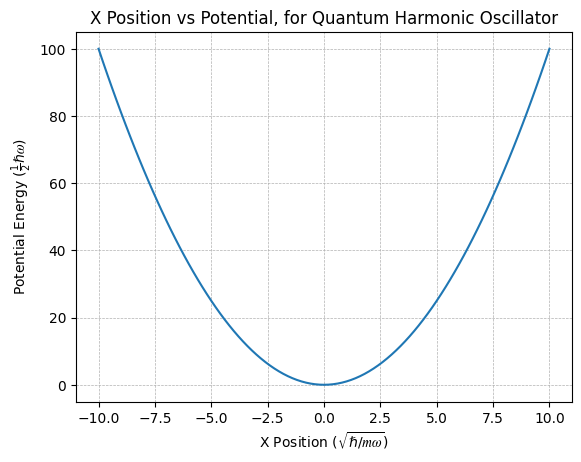

In [37]:
### - Plotting Potential for Quantum Harmonic Oscillator

# Plot Setup
title = "X Position vs Potential, for Quantum Harmonic Oscillator" 
xlabel = "X Position $(\sqrt{ℏ/𝑚𝜔})$"                        
ylabel = "Potential Energy $(\\frac{1}{2}ℏ𝜔)$" 

# Plotting Potential Energy
plt.plot(x, V_qho)                                                 
plt.title(title)               
plt.xlabel(xlabel)             
plt.ylabel(ylabel)             
plt.grid(linestyle = '--', linewidth = 0.5)                            
plt.show()

In [38]:
# print first 10 eigenvalues
print("First 10 Eigenvalues of Quantum Harmonic Oscillator")
print(E_vals_tridiag[:10])


First 10 Eigenvalues of Quantum Harmonic Oscillator
[ 0.9974937   2.98744303  4.96727726  6.93691745  8.89628257 10.84528944
 12.78385258 14.71188413 16.62929376 18.53598851]


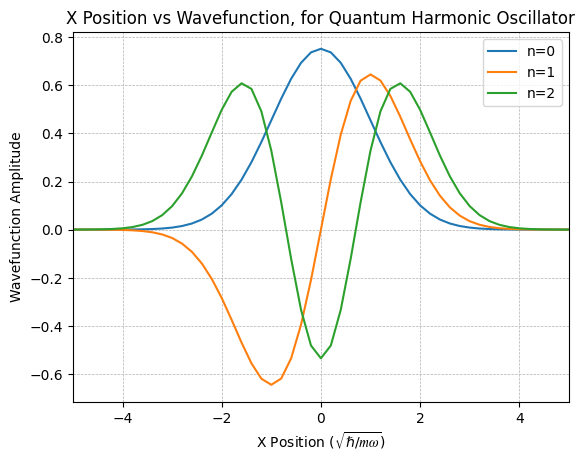

In [39]:
### - Plotting First 3 Eigenfunctions for Quantum Harmonic Oscillator

# Plot Setup
title = "X Position vs Wavefunction, for Quantum Harmonic Oscillator"
xlabel = "X Position $(\sqrt{ℏ/𝑚𝜔})$"
ylabel = "Wavefunction Amplitude"

# Plotting Wavefunctions
plt.plot(x, E_vectors_tridiag[:,0], label='n=0')
plt.plot(x, E_vectors_tridiag[:,1], label='n=1')
plt.plot(x, E_vectors_tridiag[:,2], label='n=2')
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(-5, 5)
plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()


Explain tthe above


Now we will compare them to analytical solutions.

###  analytical solution 


QHO energy **eigenvalues** $E_n$ given by:



$$
E_n = \left( n + \frac{1}{2} \right) \hbar \omega
$$

Where:
- $n$ is a non-negative integer representing the quantum number of the energy level.

This equation represents the quantization of energy levels in the quantum harmonic oscillator. Each energy level is equally spaced, with a separation of $\hbar \omega$ between adjacent levels so the energy eigenvalues are simply $n + \frac{1}{2}$.

Given we are expressing energy in terms of $\frac{1}{2} \hbar \omega$, the energy levels simplify to odd integers given by $2n + 1$. 

In [40]:
### - Analytical Quantum Harmonic Oscillator Eigenvalues
def qho_analytical_e_vals(maxE_val):
    """
    Input: maxE_val: maximum desired eigenvalue
    
    Returns: analytical_E_vals: 1D list of analytical eigenvales for the QHO from ground state up till maxE_val
             n_vals: 1D list of index positions for the analytical eigenvales
    """    
    n_vals= np.arange(0,maxE_val,1)                #Initialises list to hold the index values for the analytical eignevalues
    analytical_E_vals = 2 * n_vals + 1             #Calculates the analytical eigenvalues, which are given by (n*2)+1 due to the choice of units we have used for energy (1/2)*ℏ𝜔

    return(analytical_E_vals, n_vals)              #Returns the list of eigenvalues and the list of index values

Comparing the analytical and numerical solutions, we can see that our simulation is working correctly at low energy levels.

<div align="center">

| n   | Analytical Result         | in terms of $\frac{1}{2}ℏ𝜔$ | Simulation Result | Simulation Error |
|-----|----------------|-------------------|-------------------|------|
| 0   | $\frac{1}{2}ℏ𝜔$  | 1                 | 1.00              |0.00|
| 1   | $1\frac{1}{2}ℏ𝜔$ | 3                 | 3.00              |0.00|
| 2   | $2\frac{1}{2}ℏ𝜔$ | 5                 | 4.99              |0.01|
| 3   | $3\frac{1}{2}ℏ𝜔$ | 7                 | 6.98              |0.02|
| 4   | $4\frac{1}{2}ℏ𝜔$ | 9                 | 8.97              |0.03|
| 5   | $5\frac{1}{2}ℏ𝜔$ | 11                | 10.96             |0.04|
| 6   | $6\frac{1}{2}ℏ𝜔$ | 13                | 12.95             |0.05|
| ... | ...            | ...               | ...               |...|


</div>

The analytical **eigenvectors** are given by the Hermite polynomials, along with a gaussian factor and a normalization constant:

$$
\psi_n(x) = \frac{1}{\sqrt{2^n n! \sqrt{\pi}}} e^{-\frac{x^2}{2}} H_n(x)
$$

Where $\frac{1}{\sqrt{2^n n! \sqrt{\pi}}}$ is the normalization constant, $e^{-\frac{x^2}{2}}$ is the gaussian factor and $H_n(x)$ is the Hermite polynomial of degree $n$, given by,

$$
H_n(x) = (-1)^n e^{x^2} \frac{d^n}{dx^n} e^{-x^2}
$$




In [41]:

### - QHO Analytical Eigenvectors Function
def qho_analytical_e_vectors(x, n):
    """
    Input: x: range of x to calculate eigenvector over
           n: energy eigenvalue index of eigenvector to return
    
    Returns: wavefunc: The eigenvector of energy E_n over the range x
             prob_density: The probability density (wavefunction**2) over range x 
    """

    term_n = [((1/(np.sqrt(np.pi)))**(1/2)) * np.exp(-(x**2)/(2)),                                  #Analytical Eigenvector 1
              ((2/(np.sqrt(np.pi)))**(1/2)) * (x) * np.exp(-(x**2)/(2)),                            #Analytical Eigenvector 2
              ((2/(np.sqrt(np.pi)))**(1/2)) * ((x**2)-(1/2)) * np.exp(-(x**2)/(2)),                 #Analytical Eigenvector 3
              (2 * ((1/(3 * np.sqrt(np.pi)))**(1/2)) * (x) * ((x**2)-(3/2)) * np.exp(-(x**2)/(2)))] #Analytical Eigenvector 4       
    
    wavefunc = term_n[n]                #Selects the analytical eigenvector from above list corresponding to the input value n
    prob_density = wavefunc**2          #Squares the wavefunction to arrive at the probability density
    return (wavefunc, prob_density)     #Returns the wavefunction and probability density 

# new programatic e vectors calulation for QHO
def generate_terms(x, max_n):
    wavefunc = []
    probability_density = []
    for n in range(max_n):
        prefactor = (1 / np.sqrt(2**n * np.math.factorial(n) * np.sqrt(np.pi)))
        hermite = np.polynomial.hermite.Hermite([0]*n + [1])(x)  # Calculate the Hermite polynomial of order n
        gaussian = np.exp(-x**2 / 2)  # Gaussian function
        term = prefactor * hermite * gaussian  # Multiply Hermite polynomial by Gaussian
        wavefunc.append(term)
        probability_density.append(term**2)

    return wavefunc, probability_density

C:\Users\Ada\AppData\Local\Temp\ipykernel_36076\3560613599.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)            #Numerical Eigenvectors


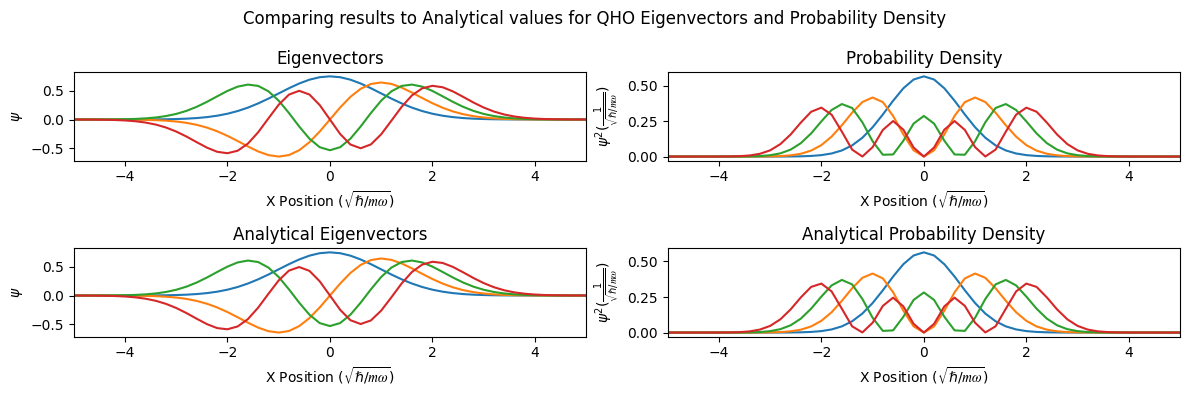

In [42]:
### - Plotting Comparison of QHO !Eigenvectors! results to Analytical Soloutions
xlabel1 = 'X Position $(\sqrt{ℏ/𝑚𝜔})$'  
ylabel1 = '$\psi$'
ylabel2 = '$\psi^2 (\\frac{1}{\sqrt{ℏ/𝑚𝜔}})$'
title1 = 'Eigenvectors'
title2 = "Probability Density"
x_limits = (-5,5)




plt.subplots(figsize=(12, 4), tight_layout=True)
plt.suptitle("Comparing results to Analytical values for QHO Eigenvectors and Probability Density")

plt.subplot(2,2,1)            #Numerical Eigenvectors
for n_indx in range (0,4):
    SimplePlotAssist(x, E_vectors_tridiag[:,n_indx], title=title1, xlabel=xlabel1, ylabel=ylabel1)
    plt.xlim(x_limits)

plt.subplot(2,2,2)            #Numerical Probability Density
for n_indx in range (0,4):
    SimplePlotAssist(x, E_vectors_tridiag[:,n_indx]**2, title=title2, xlabel=xlabel1, ylabel=ylabel2)
    plt.xlim(x_limits)

plt.subplot(2,2,3)            #Analytical Eigenvectors
for n_indx in range (0,4):
    analytical_wavefunc = qho_analytical_e_vectors(x, n_indx)[0]
    SimplePlotAssist(x, analytical_wavefunc, title="Analytical " + title1, xlabel=xlabel1, ylabel=ylabel1)
    plt.xlim(x_limits)

plt.subplot(2,2,4)            #Analytical Probability Density
for n_indx in range (0,4):
    analytical_probability = qho_analytical_e_vectors(x, n_indx)[1]
    SimplePlotAssist(x, analytical_probability, title="Analytical " + title2, xlabel=xlabel1, ylabel=ylabel2)
    plt.xlim(x_limits)

plt.show()    

For our eigenstates to represent physical states, they must be normalized. The normalization condition for the wavefunction is:

$$\int_{-\infty}^{\infty} |\psi(x)|^2 dx = 1$$

i.e. when integrated over all space, the probability density $\psi(x)^2$ must sum to 1, ensuring that the particle is somewhere in space.

We can verify analytically that our ground state wavefunction is normalized. The ground state wavefunction is given by:

$$
\psi_0(x) = \left( \frac{m\omega}{\pi\hbar} \right)^{1/4} e^{-\frac{m\omega x^2}{2\hbar}}
$$

In the Rydburg atomic unit system we are using this amounts to 
$$
\psi_0(x) = \frac{e^{-\frac{x^2}{2}}}{\pi^{1/4}}
$$

Solving the integral shows that the wavefunction is correctly normalized:

$$
\int_{-\infty}^{\infty} \left(\frac{e^{-\frac{x^2}{2}}}{\pi^{1/4}}\right)^2 dx = 1
$$

The integral of the square of the wavefunction is equal to 1, which means the wavefunction is normalized and its square represents the probability density of finding the particle at a given position with physical significance.

In [43]:
# integral check 

# Perform numerical integration using the trapezoidal rule
integral = np.trapz(E_vectors_tridiag[:,n_indx]**2, x)

print("Integral:", integral)
"""
max_n = 4
analytical_qho_evecs, analytical_qho_pdensity = generate_terms(x, max_n)

for analytical_evec, analytical_pdensity in zip(analytical_qho_evecs, analytical_qho_pdensity):
    # Perform numerical integration using the trapezoidal rule
    integral = np.trapz(analytical_pdensity, x)

    print("Integral:", integral)



    plt.plot(x, analytical_evec, label="Wavefunction")
    plt.plot(x, analytical_pdensity, label="Probability Density")
    plt.legend()
    plt.show()
"""

Integral: 0.999999999999996


'\nmax_n = 4\nanalytical_qho_evecs, analytical_qho_pdensity = generate_terms(x, max_n)\n\nfor analytical_evec, analytical_pdensity in zip(analytical_qho_evecs, analytical_qho_pdensity):\n    # Perform numerical integration using the trapezoidal rule\n    integral = np.trapz(analytical_pdensity, x)\n\n    print("Integral:", integral)\n\n\n\n    plt.plot(x, analytical_evec, label="Wavefunction")\n    plt.plot(x, analytical_pdensity, label="Probability Density")\n    plt.legend()\n    plt.show()\n'

For a more detailed comparison, including testing the accuracy as a fucntion of input parameters and on the stability of the numerical solution, as well as the reasoning behind the currently selected input parameters see [Readme Appendix Section 2.1](#Appendix_stability).

Now we have verified our simulation we can demonstrate the results:



??? the wavefunctions $\psi$, the probability density, which is given by $\psi^2$, and indicates the probability to find the particle at position $x$.

In [44]:
### - Function for QHO - (Now with the testing done clean function for the whole QHO calculation without all the testing loops and analytical checking etc, and only using the prefered scipy solver, eigh.tridiag)
def QHO_Calculator(N, maxE_val):
    """
    Input: N: Int value for number of points to divide the spatial range into, 
           maxE_val: maximum desired eigenvalue, 
    
    Returns:x: Discrete x values as N x 1 array, 
            delta_x: The step size (dx) as a single float,
            N: Int value for number of points to divide the spatial range into,
            V_qho:, Potential Energy values as N x 1 array,
            E_vals_tridiag: List of numerically calculated eigenvalues, 
            E_vectors_tridiag List of numerically calculated eigenvectors
    """  
    x, delta_x, N = generate_x(x_min=-5, x_max=5, N=N)                           #Spatial Discretisation  function 
    V_qho = potential_qho(x)                                                     #QHO potential function
    H_main, H_plusone = hamiltonian_diag(x, V_qho, delta_x)                      #Hamiltonian function
    E_vals_tridiag, E_vectors_tridiag = eigh_tridiagonal(H_main, H_plusone)      #Eigen vector/value solver
    E_vectors_tridiag = E_vectors_tridiag / np.sqrt(delta_x)                    #Normalising the eigenvectors

    return x, delta_x, N, V_qho, E_vals_tridiag, E_vectors_tridiag              #Returns all calulated values and steps for further processing or visulisation

In [45]:
x, delta_x, N, V_qho, E_vals_tridiag, E_vectors_tridiag = QHO_Calculator(10000, maxE_val=100);

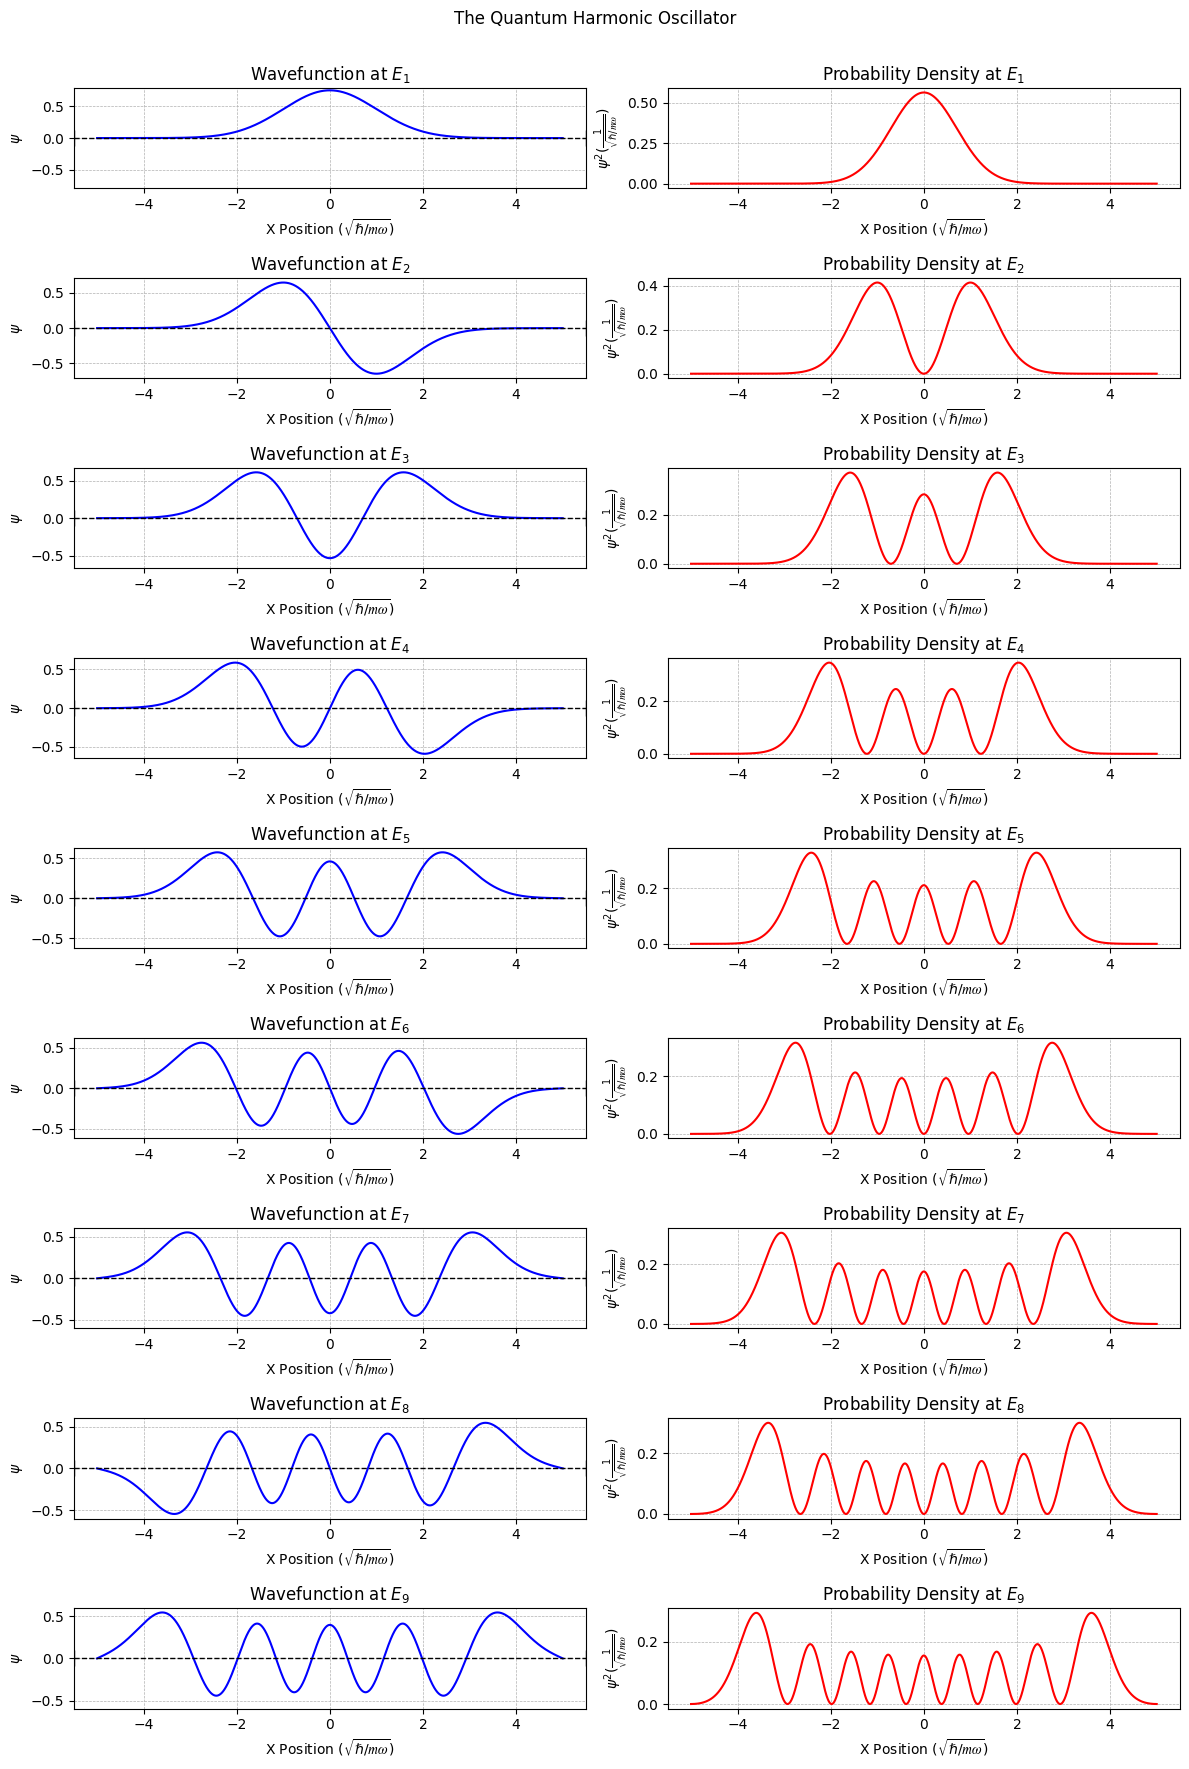

In [46]:
### - Seperate Eigenstate (Wavefunction) and Probability Density (Wavefunction**2) Plots for Quantum Harmonic Oscillator

#User Settings
maxE_vec = 9    # Max number of eigenvectors to plot

#Plot - Setup
title = "Wavefunction at "   #is appended with the eigenstate number in the plot
title_2 = "Probability Density at "
xlabel = "X Position $(\sqrt{ℏ/𝑚𝜔})$"
ylabel = "$\psi$" 
ylabel_2 = "$\psi^2 (\\frac{1}{\sqrt{ℏ/𝑚𝜔}})$" 

#Plotting
rows=maxE_vec
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(12, rows*2), tight_layout=True)
plt.suptitle("The Quantum Harmonic Oscillator\n \n ")

for i_ax, ax in enumerate(axes.flat):
    n = i_ax//2
    if ((i_ax) % 2) == 0:          #WAVEFUNCTION PSI
        SimplePlotAssist(x, E_vectors_tridiag[:,n], xlabel=xlabel, ylabel=ylabel, ax_mode=1, title=title + "$E_%s$" %(n+1), symetrical=1)
        ax.axhline(y=0 , color='black', marker='|', linestyle='dashed', linewidth=1, markersize=12)
        ax.grid(linestyle = '--', linewidth = 0.5)

    else:                          #PROBABILITY PSI**2
        SimplePlotAssist(x, E_vectors_tridiag[:,n]**2, xlabel=xlabel, ylabel=ylabel_2, colour='r', ax_mode=1, title=title_2 + "$E_%s$" %(n+1))    
        ax.grid(linestyle = '--', linewidth = 0.5)
        
plt.show()

discuss meaning

## Putting it all together

Here we will make a single set of plots which will combine all the infromation we have gathered so far. We again show the wavefunctions on the left and the probability density functions on the right hand plot, however this time we overlay the potential, and we plot the wavefunctions and probability densities at thier corresponding energy eigenvalues, demonstrating the relationship between the potential, the energy levels and the wavefunctions. This gives a good visual representation of the quantum harmonic oscillator, and of many of the most important concepts in quantum mechanics, i.e, the quantization of energy levels, wave-particle duality, quantum tunneling, and xxxxxxxxxxxxxxxxxx

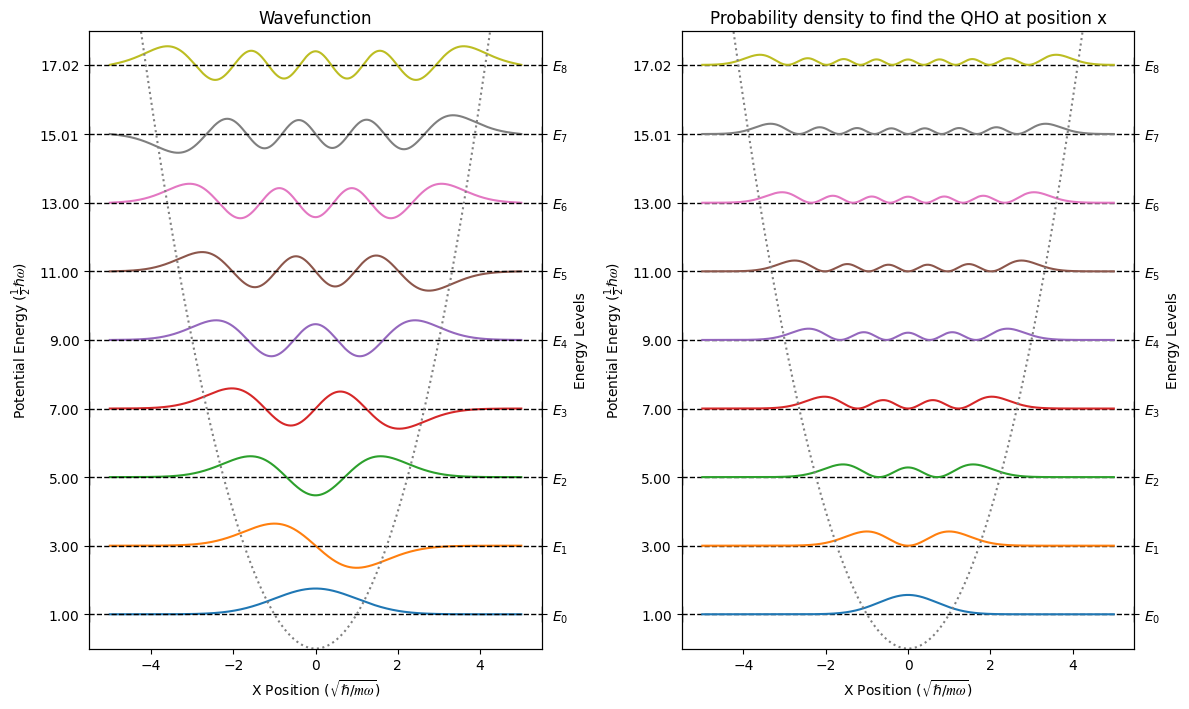

In [47]:
### - Condensed Wavefunction and Probability Density Plots for Quantum Harmonic Oscillator Showing Potential 

#Plot - Setup
title = "Wavefunction"
title_2 = "Probability density to find the QHO at position x"
xlabel = "X Position $(\sqrt{ℏ/𝑚𝜔})$"
ylabel = "Wavefunction $(\psi)$" # (𝜓)")#font error on psi
ylabel_2 = "Probability Density" # (𝜓2)")#font error on psi
boost_wave_amplitude_visibility = 1
boost_prob_amplitude_visibility = 1

#Internal Program Setup 
Eslice = E_vectors_tridiag[:,0:maxE_vec]
EvalSlice = E_vals_tridiag[0:maxE_vec]

#Changes plot height scaling factor when under 4 plots high to keep pleasent viewing size
if maxE_vec <= 4:
    scaled_height = 2 * maxE_vec
else:
    scaled_height = 0.8 * maxE_vec

### - Plotting    
plt.subplots(nrows=1, ncols=2, figsize=(12, scaled_height), tight_layout=True)
y_ticks = []
tick_locations = []
tick_locations_2 = []


plt.subplot(1,2,1)                    #WAVEFUNCTION PSI
for n in range(0, maxE_vec):
    offset = EvalSlice[n]                  #Sets an ofset scaling value so that each successive wavefunction is is offset from the previous on the plot
    y_ticks.append("$E_%s$" %(n))   #Sets the y axis labeles with the corresponding eigenvalue index E_n
    tick_locations.append(offset)     #Sets the y axis tick locations to fall on each ofset waves centre
    ylabel = "Potential Energy $(\\frac{1}{2}ℏ𝜔)$"
    
    SimplePlotAssist(x, Eslice[:,n]*boost_wave_amplitude_visibility+ offset, title=title, xlabel=xlabel, ylabel=ylabel)               #Plots wavefunction against spatial range x
    plt.axhline(y=offset, color='black', marker='|', linestyle='dashed', linewidth=1, markersize=12)   #Adds a central line indicating y = 0 as a guide to the eye 

#plt.yticks(ticks=tick_locations, labels=y_ticks)       #Plots the created y labels
plt.plot(x, V_qho, c='grey', linestyle='dotted')       #Once all wavefunctions are plotted, this line plots the potential we calulated earlier on the same graph to visualise the classical limits
plt.ylim(0,18)                                      #This just trims the potential to the same limits as the wavefunction graph so it is displayed at correct scaling reletive to the probability density plot beside
plt.yticks(ticks=tick_locations)       #Plots the created y labels


# cretaa  a secondary y axis on the right hand side of the plot
ax2 = plt.twinx()
ax2.set_yticks(ticks=tick_locations, labels=y_ticks)       #Plots the created y labels
ax2.set_ylim(0,18)                                      #This just trims the potential to the same limits as the wavefunction graph so it is displayed at correct scaling reletive to the probability density plot beside
ax2.set_ylabel("Energy Levels")

plt.subplot(1,2,2)                     #PROBABILITY PSI**2
for n in range(0, maxE_vec):           #Sets an ofset scaling value so that each successive probability density plot is is offset from the previous on the plot
    offset = EvalSlice[n]                  #Sets an ofset scaling value so that each successive wavefunction is is offset from the previous on the plot
    tick_locations_2.append(offset)    
    ylabel_2 = "Energy Levels"
    plt.axhline(y=offset, label="$E_%s$" %(n), color='black', marker='|', linestyle='dashed', linewidth=1, markersize=12)
    SimplePlotAssist(x, (Eslice[:,n]**2) * boost_prob_amplitude_visibility + offset, title=title_2, xlabel=xlabel, ylabel=ylabel)       #Plots probability density against spatial range x


plt.plot(x, V_qho, c='grey', linestyle='dotted')       #Once all wavefunctions are plotted, this line plots the potential we calulated earlier on the same graph to visualise the classical limits
plt.ylim(0,18)                                      #This just trims the potential to the same limits as the wavefunction graph so it is displayed at correct scaling reletive to the probability density plot beside
plt.yticks(ticks=tick_locations_2) 


# cretaa  a secondary y axis on the right hand side of the plot
ax2 = plt.twinx()
ax2.set_yticks(ticks=tick_locations, labels=y_ticks)       #Plots the created y labels
ax2.set_ylim(0,18)                                      #This just trims the potential to the same limits as the wavefunction graph so it is displayed at correct scaling reletive to the probability density plot beside
ax2.set_ylabel("Energy Levels")



plt.show()




The dotted u shape line shows the potential that we caluclated, combining the potential and the wavefunctions on this one plot allows us to see the classical limits, where the potential crosses each wavefunction. Classically the wavefucntion is not allowed to have a value other than 0 past these limits (turning points) but we can see here that it does, this is one of the dissagremments between classical and quantum theory.

# Part 2
Having verified our method, we can use it to find the eigenvalues of a more complex system - the Hydrogen atom.  In a spherically symmetric system, the wavefunction can be written :

$$\frac{1}{r}\Psi(r)Y_{lm}(\theta, \phi)e^{i m\phi}$$

where $Y_{lm}(\theta, \phi)$ are the spherical harmonic functions and l, m are the angular momentum quantum numbers. The radial function $\Psi(r)$ satisfies the time-independent Schrödinger equation, provided a suitable term is added to the potential.

##### Rydberg atomic units!!!!!!!!!!!!!


If we use the Bohr radius $a_0$ as the unit $r$, where :
$$a_0 = \frac{4 \pi \epsilon \hbar^2}{m_e e^2}$$

then the energy will be measured in units of :
$$
\frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}
$$

Which is approximately $13.606$ eV. This is known as the ionisation energy of hydrogen and is the energy required to remove an electron from the ground state of a hydrogen atom.

The potential for the hydrogen atom can then be written as:

$$V(r_i) = \frac{-2}{r_i} + \frac{l(l+1)}{r_i^2}$$

In [48]:
### - Potential Energy Function for Hydrogen Atom
def potential_hydrogen(r, l=0):
    """
    Input: r: Discrete radius values as N x 1 array,
           l: Angular momentum quantum number [defaults to 0 if not set]
    
    Returns: V_hyd: N x 1 array with the corresponsing potential energy of the Hydrogen electron at each radial value.
    """    
    V_hyd = -2/r + (l*(l+1)/r**2)                                 

    # check for any infinities or NaNs in the potential array and set them to very small value
    V_hyd[np.isnan(V_hyd)] = 1e-20

    return V_hyd                                         #Returns the potential energy of the hydrogen electron across the radial range r

Everything else is the same as the quantum harmonic oscillator, and we can use the same method we developed to find the eigenvalues and eigenvectors of the Schrödinger equation now with the hydrogen atom potential.

In [49]:
l = 0 

r, delta_r, N = generate_x(x_min=0, x_max=200, N=1000)    #X spatial genrator fucntion defined earlier works fine for r too

#Calculate Potential using function
V_hydrogen = potential_hydrogen(r, l)     #Runs above function to calcualte the potential of the hydrogen atom 

# Hamiltonian function running on hydrogen potential
H_main_hydrogen, H_plusone_hydrogen = hamiltonian_diag(r, V_hydrogen, delta_r)   #The main diagonal of the Hamiltonian matrix and the ofset diagonal 

# Eigenvalue & Eigenvector Solver for hydrogen
E_vals_hydrogen, E_vectors_hydrogen = eigh_tridiagonal(H_main_hydrogen, H_plusone_hydrogen)   # use range args to simplify 

print(E_vals_hydrogen[0:10])
print(convert_potential_to_eV(E_vals_hydrogen[0:10]))

C:\Users\Ada\AppData\Local\Temp\ipykernel_36076\495957729.py:9: RuntimeWarning: divide by zero encountered in divide
  V_hyd = -2/r + (l*(l+1)/r**2)
C:\Users\Ada\AppData\Local\Temp\ipykernel_36076\495957729.py:9: RuntimeWarning: invalid value encountered in divide
  V_hyd = -2/r + (l*(l+1)/r**2)


[-1.61468924 -0.31417709 -0.12909543 -0.06988431 -0.0437207  -0.0299083
 -0.0217398  -0.01651205 -0.01295309 -0.01015074]
[-21.96946178  -4.27469354  -1.7564724   -0.95084591  -0.5948638
  -0.40693236  -0.29579171  -0.22466293  -0.17623979  -0.13811102]


##  Analytical soloution: 
Determining the energy levels (n1, n2, n3, etc.) for the hydrogen atom potential involves solving the Schrödinger equation for the hydrogen atom. The Schrödinger equation describes how the wave function of a particle (in this case, the electron in the hydrogen atom) evolves over time.

For the hydrogen atom, the Schrödinger equation can be solved exactly due to its simple structure. The solutions yield a set of discrete energy levels characterized by the principal quantum number, $n$. These energy levels correspond to different electron orbitals.

The energy levels for the hydrogen atom are given by the formula:

$$E_n = − \frac{R_H}{n^2}​$$

Where:

$E_n$ is the energy of the level.
$R_H$​ is the Rydberg constant for hydrogen ($R_H$ = 13.6 electron volts).
$n$ is the principal quantum number.

These energy levels are quantized, meaning they can only take on specific values determined by the integer values of nn (1, 2, 3, ...).

In [50]:
# other method, probably same, rydburg probably is combination of these other constants 
def hydrogen_energy_analytical(max_n):
    # Constants
    m_e = 9.10938356e-31  # Mass of the electron in kg
    e = 1.602176634e-19  # Elementary charge in C
    epsilon_0 = 8.854187817e-12  # Vacuum permittivity in F/m
    h = 6.62607015e-34  # Planck constant in J s
    
    energy_levels = []  
    for n in range(1, max_n + 1):
        E_n_Joules = - (m_e * e**4) / (8 * epsilon_0**2 * h**2) * (1 / n**2)             # Energy eigenvalue formula
        E_n_eV = E_n_Joules / e                                                          # Convert to electron volts
        energy_levels.append(E_n_eV)

    return energy_levels

# Example usage:
max_n = 10
energies = hydrogen_energy_analytical(max_n)
for n, energy in enumerate(energies, start=1):
    print(f"Energy level n={n}: {energy:.2f} eV")


Energy level n=1: -13.61 eV
Energy level n=2: -3.40 eV
Energy level n=3: -1.51 eV
Energy level n=4: -0.85 eV
Energy level n=5: -0.54 eV
Energy level n=6: -0.38 eV
Energy level n=7: -0.28 eV
Energy level n=8: -0.21 eV
Energy level n=9: -0.17 eV
Energy level n=10: -0.14 eV


We can see how the potential energy gradient is differnt in each case, the QHO on the right is a parabola with the lowest energy at the zero displacement point (x=0), additonally the potential enegy values are positive. In contrast the Hydrogen potential energy (shown on the left), is 0 at r=0 as this is the point where the nucleus exists (in this approximation the nucleus is a point charge) the potential is negative values as the electron is bound to the nucleus. The shape of the hydrogen potential shows us that energy is required to move the electron away from the nucleus

The potential well of the hydrogen atom is created by the positivly charged nucleus which attracts the negatively charged electron. The electron in the hydrogen atom is trapped in the well, in what is known as a bound state. If the electron in the well is provided enough energy it can escape the well, this is known as ionisation, i.e where a atom looses one/some of its electrons. The energy required to remove the electron from the well is the ionisation energy, for hydrogen this is 13.6 eV for reasons we shall see shortly. The energy levels of the hydrogen atom are quantised, meaning they can only take on specific values determined by the integer values of n (1, 2, 3, ...), however there are infinatly many energy levels. The energy levels are negative, this is because the electron is bound to the nucleus and it requires energy to remove it from the well.


C:\Users\Ada\AppData\Local\Temp\ipykernel_36076\495957729.py:9: RuntimeWarning: divide by zero encountered in divide
  V_hyd = -2/r + (l*(l+1)/r**2)
C:\Users\Ada\AppData\Local\Temp\ipykernel_36076\495957729.py:9: RuntimeWarning: invalid value encountered in divide
  V_hyd = -2/r + (l*(l+1)/r**2)
C:\Users\Ada\AppData\Local\Temp\ipykernel_36076\495957729.py:9: RuntimeWarning: invalid value encountered in add
  V_hyd = -2/r + (l*(l+1)/r**2)


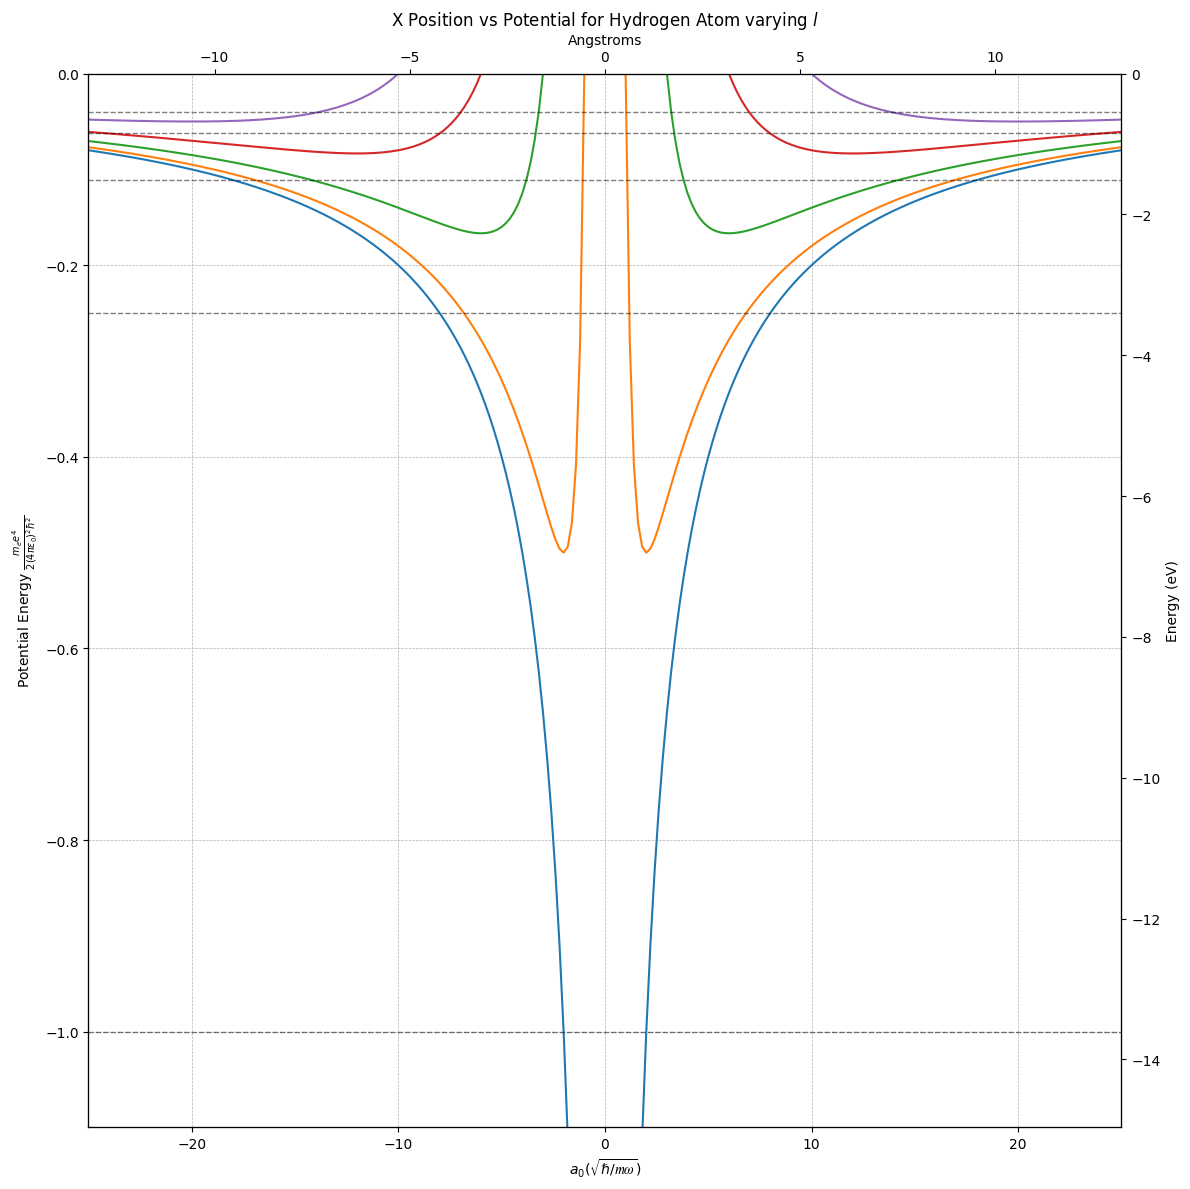

In [51]:
### - Calulate & Plotting Potential for Hydrogen Atom
lower_limit = -25
upper_limit = 25

#Plot Setup
plt.subplots(figsize=(12, 12), tight_layout=True)

#Hydrogen Atom Plot Setup
title = "X Position vs Potential for Hydrogen Atom varying $l$" 
xlabel = "$a_0 (\sqrt{ℏ/𝑚𝜔})$"                  # Text encapsulated within two $ signs is rendered as latex, needed it to use non standard charecters i.e hbar, psi, etc 
ylabel = "Potential Energy $\\frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$" 


for lval in range (0, 5):
    #Calculate Potential using function
    V_hydrogen_test = potential_hydrogen(r, l=lval)     #Runs above function to calcualte the potential of the hydrogen atom
    
    # check for any negative values in the potential array - (If there are no values below 0 then the potential is not plotted as it is not a valid binding potential)??
    if np.any(V_hydrogen < 0):
        
        # remove all positive values
        V_hydrogen_test[V_hydrogen_test > 0] = np.nan

        #Hydrogen Atom Plotting
        plt.subplot(1,1,1)
        SimplePlotAssist(r, V_hydrogen_test, title=title, xlabel=xlabel, ylabel=ylabel)  #Plots the hydrogen atom potential 
        
        # get the last used mpl colour 
        colour = plt.gca().lines[-1].get_color()
        plt.plot(-r,V_hydrogen_test, c=colour)                                        #Plots mirror image of the one sided hydrogen potential calcuated so it is reflected across x=0 as to compare to the QHO, colour used (c="#1f77b4") is the default matplotlib first plot colour so as to match the first half 
        #plt.ylim(-2, 0.5)
    
    else:
        print("No valid binding potential found for l =", lval)





plt.grid(linestyle = '--', linewidth = 0.5)                                 #Adds grid to the plot to make it easier to read off values visualy

plt.ylim(-1.1, 0.1)
#plt.axhline(y=0 , color='black', marker='|', linestyle="solid", linewidth=1, markersize=12)
plt.xlim(lower_limit, upper_limit)


# add a new x axis on the top of the plot
ax2 = plt.twiny()
# set label for the new x-axis
ax2.set_xlabel('Angstroms')

# set new x-axis limits as the min and max angstrom values
ax2.set_xlim(bohr_radius_to_angstrom(lower_limit), bohr_radius_to_angstrom(upper_limit))


# get the limits of the y axis on the left hand side plot
ymin, ymax = plt.ylim()
ax3 = plt.twinx()
ax3.set_ylabel('Energy (eV)')
ax3.set_ylim(convert_potential_to_eV(ymin), convert_potential_to_eV(ymax))

energies = hydrogen_energy_analytical(5)
for n, energy in enumerate(energies, start=1):
    plt.axhline(y=energy, color='black', linestyle='dashed', linewidth=1, label=f"n=${n}$", alpha=0.5)




plt.show()

we can see clearly from the potential plots why the quantum numbe rl is limited to n-1 as the eignestate for any given n dosent have the required energy level to exist in the energy wells for l values greater than n-1. 

this alos gives us some insight into why the ionisation energy of hydrogen is 13.6 eV, as this is the energy required to remove the electron from the ground state of the hydrogen atom, and the ground state of the hydrogen atom is the lowest energy level, n=1, so the ionisation energy is the energy difference between the ground state and the point where the electron is free from the nucleus, i.e the energy difference between the ground state and the point where the electron is at infinity, which is 0. 

Now re-use the `hamiltonian()` function to generate the Hamiltonian matrix for the Hydrogren atom, and find at least the first 5 eigenvalues for at least l=0. Compare these eigenvalues with the expected eigenvalues.

In [52]:
### - Analytical Hydrogen Electron Eigenvalues
def hydrogen_analytical_e_vals(maxE_val):
    """
    Input: maxE_val: maximum desired eigenvalue
    
    Returns: hydrogen_analytical_E_vals: 1D list of analytical eigenvalues for the hydrogen atom from ground state up till maxE_val
             hydrogen_n_vals: 1D list of index positions for the analytical eigenvalues    
    """
    
    hydrogen_analytical_E_vals=[]                         #Initialises list to hold the analytical hydrogen eignevalues
    hydrogen_n_vals=[]                                    #Initialises list to hold the hydrogen index n 
    
    for n in range (1,maxE_val+1):                          #Iterates through the values of n up to the maximum user desired eignevalue (maxE_val)
        Esub_n = -1/(n**2)                                #Calculates the analytical eigenvalues, which are given by -1/(n**2) due to the choice of units we have used for energy (XXXXXXXXXXXXXXXXXXXXX)
        hydrogen_analytical_E_vals.append(Esub_n)         #Appends calulated analytical eigenvalue to the list) 
        hydrogen_n_vals.append(n)                         #Appends the index to its list 
    return(hydrogen_analytical_E_vals, hydrogen_n_vals)   #Returns the list of eigenvalues and the list of index values
print(hydrogen_analytical_e_vals(10)[0])
print(convert_potential_to_eV(np.array(hydrogen_analytical_e_vals(10)[0])))

[-1.0, -0.25, -0.1111111111111111, -0.0625, -0.04, -0.027777777777777776, -0.02040816326530612, -0.015625, -0.012345679012345678, -0.01]
[-13.606       -3.4015      -1.51177778  -0.850375    -0.54424
  -0.37794444  -0.27767347  -0.21259375  -0.16797531  -0.13606   ]



| n   | Analytical Result | in terms of $\frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$ | Simulation Result | Simulation Error |
|-----|------------------|-------------------------------|-------------------|------|
| 0   | $-1.000 \frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$  | -1.0000                      | -1.0433           |-0.0433|
| 1   | $-0.250 \frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$ | -0.2500                      | -0.2553           |-0.0053|
| 2   | $-0.111 \frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$ | -0.1111                      | -0.1127           |-0.0017|
| 3   | $-0.063 \frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$ | -0.0625                      | -0.0632           |-0.0007|
| 4   | $-0.040 \frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$ | -0.0400                      | -0.0403           |-0.0003|
| 5   | $-0.027 \frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$ | -0.0278                      | -0.0280           |-0.0002|
| 6   | $-0.020 \frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$ | -0.0204                      | -0.0205           |-0.0001|
| ... | ...            | ...               | ...               |...|


Finally, as for the quantum harmonic oscillator, plot the wavefunctions.

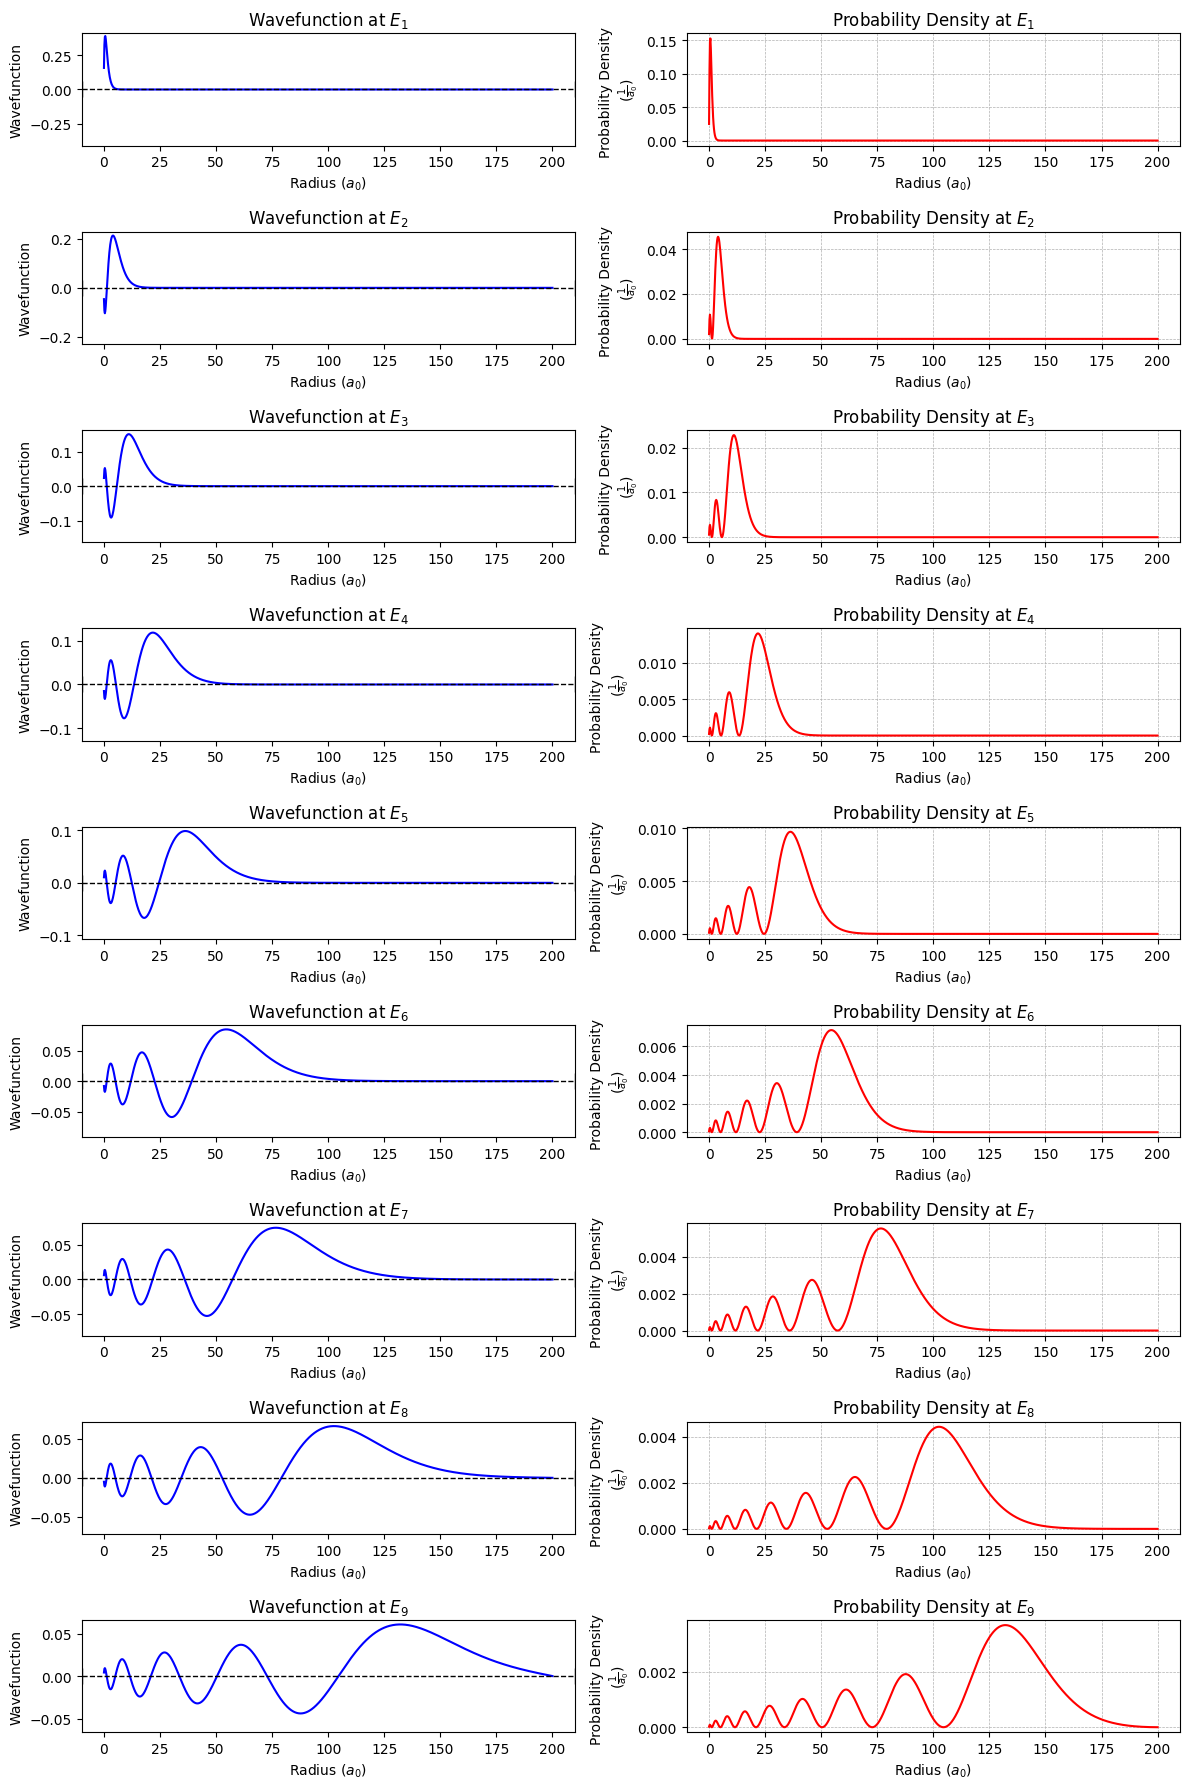

In [53]:
### - Seperate Eigenstate (Wavefunction) and Probability Density (Wavefunction**2) Plots for Hydrogen Atom

#Plot - Setup
title = "Wavefunction at "           #Is appended with the eigenstate number in the plot
title2 = "Probability Density at "   #Is appended with the eigenstate number in the plot
xlabel = "Radius ($a_0$)"
ylabel = "Wavefunction"             
ylabel_2 = "Probability Density \n($\\frac{1}{a_0}$)" 

#Plotting
n=1                                  #Initialises loop counter as i from enumerate is not in sync
rows = maxE_vec                      #Defines the number of rows for the plot based on the number of plots selected
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(12, rows *2), tight_layout=True)
for i, ax in enumerate(axes.flat): 
    if ((i) % 2) == 0:            #WAVEFUNCTION PSI
        SimplePlotAssist(r, E_vectors_hydrogen[:,n-1], xlabel=xlabel, ylabel=ylabel, ax_mode=1, title=title + "$E_%s$" %(n), symetrical=1)
        ax.axhline(y=0 , color='black', marker='|', linestyle='dashed', linewidth=1, markersize=12)
    
    else:                         #PROBABILITY PSI**2
        SimplePlotAssist(r, E_vectors_hydrogen[:,n-1]**2, xlabel=xlabel, ylabel=ylabel_2, colour='r', ax_mode=1, title=title2 + "$E_%s$" %(n))    
        ax.grid(linestyle = '--', linewidth = 0.5)
        n = n+1
        
plt.show()  


description of above
 

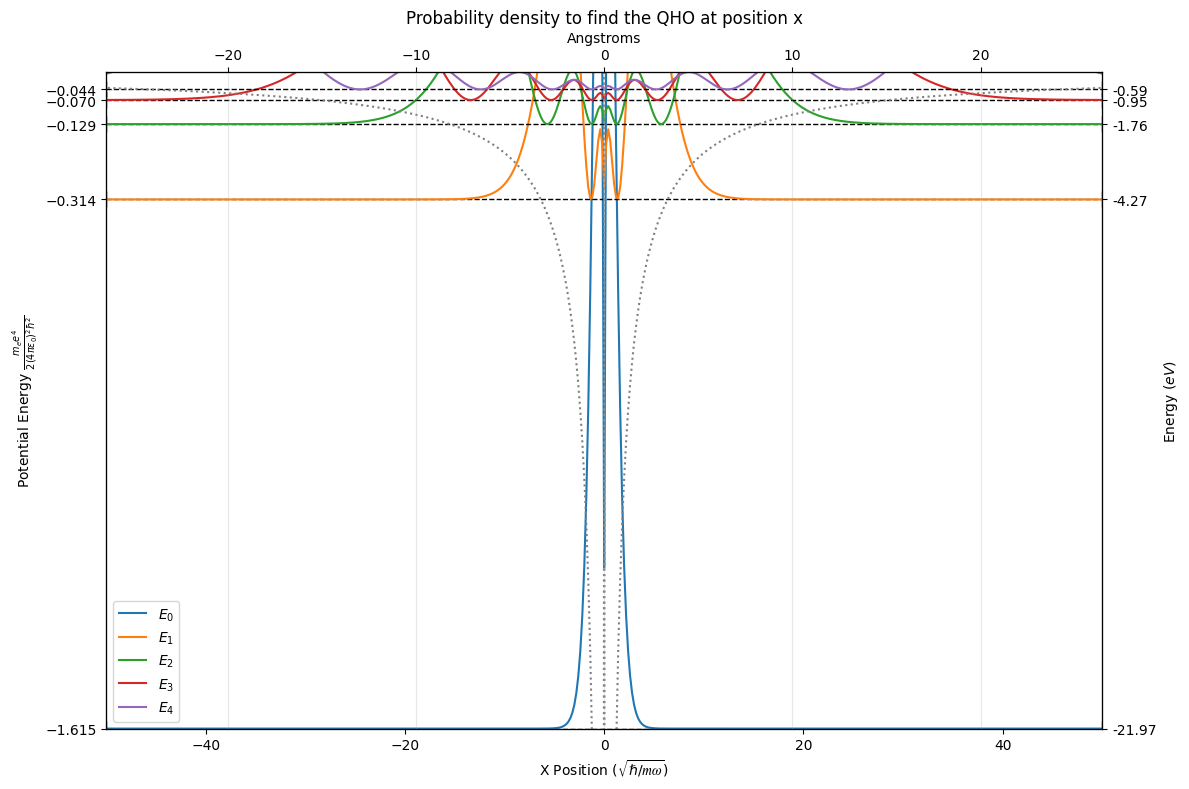

In [54]:
### - Condensed Wavefunction and Probability Density Plots for Quantum Harmonic Oscillator Showing Potential 

#Plot - Setup
title = "Wavefunction"
xlabel = "X Position $(\sqrt{ℏ/𝑚𝜔})$"
ylabel = "Potential Energy $\\frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$" 
boost_prob_amplitude_visibility = 16

maxE_vec = 5
plot_maxima = False
x_limits = -50, 50
y_limits = -1.10, 0.2


#Internal Program Setup 
Eslice = E_vectors_hydrogen[:,0:maxE_vec]
EvalSlice = E_vals_hydrogen[0:maxE_vec]


### - Plotting    
y_ticks = []
tick_locations = []
tick_locations_2 = []

plt.subplots(nrows=1, ncols=1, figsize=(12, 8), tight_layout=True)
for n in range(0, maxE_vec):           #Sets an ofset scaling value so that each successive probability density plot is is offset from the previous on the plot
    offset = EvalSlice[n]                  #Sets an ofset scaling value so that each successive wavefunction is is offset from the previous on the plot
    tick_locations_2.append(offset)    

    y_ticks.append(round((convert_potential_to_eV(offset)), 2))   #Sets the y axis labeles with the corresponding eigenvalue index E_n
    plt.axhline(y=offset, color='black', marker='|', linestyle='dashed', linewidth=1, markersize=12,)
    SimplePlotAssist(r, (Eslice[:,n]**2) * boost_prob_amplitude_visibility + offset, title=title_2, xlabel=xlabel, ylabel=ylabel)       #Plots probability density against spatial range x
    
    # get the last used mpl colour 
    colour = plt.gca().lines[-1].get_color()
    plt.plot(np.negative(r), (E_vectors_hydrogen[:,n]**2  * boost_prob_amplitude_visibility + offset), c=colour,  label="$E_%s$" %(n))                           #Again have mirrored the hydrogen data so that it covers both sides of the nucleus for visual comparison to the 2d rings image, colour used for the mirror inversion is hex code #1f77b4 which is the default matplot lib first line colour, to make it match the line above

    if plot_maxima:
        # determine all the local maxima in the probability density as a array of indices
        local_maxima_indices, local_maxima_values = find_local_maxima(Eslice[:,n]**2)

        # Adding central band of each orbital
        for i in local_maxima_indices:  
            width = r[i]*2
            height = width / 250
            ellipse = patches.Ellipse((0, offset), width, height, edgecolor=colour, facecolor='none', alpha=0.5)
            plt.gca().add_artist(ellipse)  # Use plt.gca() to get current axes    

# show a legend with the energy levels
plt.legend()

plt.plot(r, V_hydrogen, c='grey', linestyle='dotted')       #Once all wavefunctions are plotted, this line plots the potential we calulated earlier on the same graph to visualise the classical limits
plt.plot(np.negative(r), V_hydrogen, c='grey', linestyle='dotted')       #Once all wavefunctions are plotted, this line plots the potential we calulated earlier on the same graph to visualise the classical limits

plt.ylim(y_limits)                                      #This just trims the potential to the same limits as the wavefunction graph so it is displayed at correct scaling reletive to the probability density plot beside
plt.yticks(ticks=tick_locations_2) 
plt.xlim(x_limits)

# create a secondary y axis on the right hand side of the plot
ax2 = plt.twinx()
ax2.set_ylim(y_limits)                                      #This just trims the potential to the same limits as the wavefunction graph so it is displayed at correct scaling reletive to the probability density plot beside
ax2.set_yticks(ticks=tick_locations_2, labels=y_ticks)       #Plots the created y labels
ax2.set_ylabel("Energy $(eV)$")

ax2 = plt.twiny()    # add a new x axis on the top of the plot
ax2.set_xlabel('Angstroms')   # set label for the new x-axis
ax2.set_xlim(bohr_radius_to_angstrom(x_limits[0]), bohr_radius_to_angstrom(x_limits[1]))    # set new x-axis limits as the min and max angstrom values

# add grid that has its own y ticks
plt.grid(alpha=0.3)
plt.show()




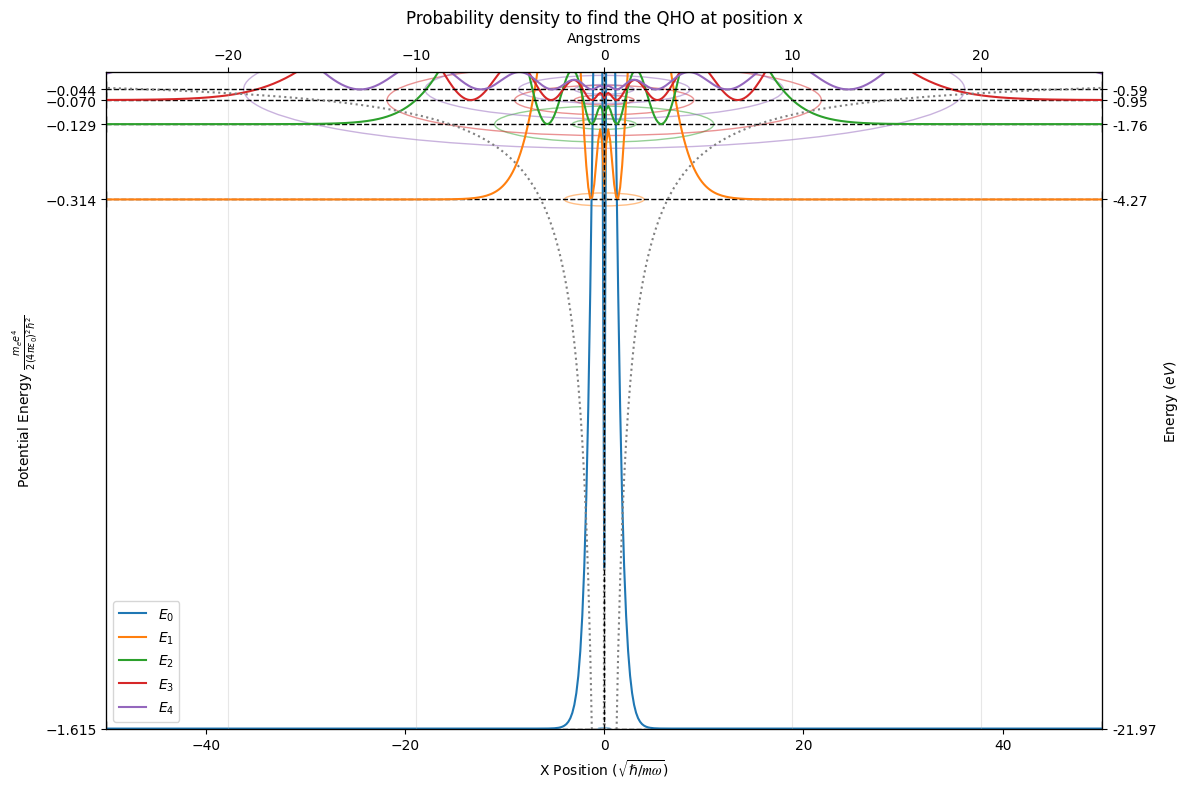

In [55]:
### - Condensed Wavefunction and Probability Density Plots for Quantum Harmonic Oscillator Showing Potential 
# Plot - Setup
title = "Wavefunction"
xlabel = "X Position $(\sqrt{ℏ/𝑚𝜔})$"
ylabel = "Potential Energy $\\frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$" 
boost_prob_amplitude_visibility = 16

plot_maxima = True
maxE_vec = 5
x_limits = -50, 50
y_limits = -1.10, 0

#Internal Program Setup 
Eslice = E_vectors_hydrogen[:,0:maxE_vec]
EvalSlice = E_vals_hydrogen[0:maxE_vec]

### - Plotting    
y_ticks = []
tick_locations_2 = []
plt.subplots(nrows=1, ncols=1, figsize=(12, 8), tight_layout=True)
for n in range(0, maxE_vec):           #Sets an ofset scaling value so that each successive probability density plot is is offset from the previous on the plot
    offset = EvalSlice[n]                  #Sets an ofset scaling value so that each successive wavefunction is is offset from the previous on the plot
    tick_locations_2.append(offset)    

    y_ticks.append(round((convert_potential_to_eV(offset)), 2))   #Sets the y axis labeles with the corresponding eigenvalue index E_n
    plt.axhline(y=offset, color='black', marker='|', linestyle='dashed', linewidth=1, markersize=12,)
    SimplePlotAssist(r, (Eslice[:,n]**2) * boost_prob_amplitude_visibility + offset, title=title_2, xlabel=xlabel, ylabel=ylabel)       #Plots probability density against spatial range x
    
    # get the last used mpl colour 
    colour = plt.gca().lines[-1].get_color()
    plt.plot(np.negative(r), (Eslice[:,n]**2  * boost_prob_amplitude_visibility + offset), c=colour,  label="$E_%s$" %(n))                           #Again have mirrored the hydrogen data so that it covers both sides of the nucleus for visual comparison to the 2d rings image, colour used for the mirror inversion is hex code #1f77b4 which is the default matplot lib first line colour, to make it match the line above

    if plot_maxima:
        # determine all the local maxima in the probability density as a array of indices
        local_maxima_indices, local_maxima_values = find_local_maxima(Eslice[:,n]**2)

        # Adding central band of each orbital
        for i in local_maxima_indices:  
            width = r[i]*2
            height = width / 250
            ellipse = patches.Ellipse((0, offset), width, height, edgecolor=colour, facecolor='none', alpha=0.5)
            plt.gca().add_artist(ellipse)  # Use plt.gca() to get current axes    

# show a legend with the energy levels
plt.legend()

plt.plot(r, V_hydrogen, c='grey', linestyle='dotted')       #Once all wavefunctions are plotted, this line plots the potential we calulated earlier on the same graph to visualise the classical limits
plt.plot(np.negative(r), V_hydrogen, c='grey', linestyle='dotted')       #Once all wavefunctions are plotted, this line plots the potential we calulated earlier on the same graph to visualise the classical limits

plt.ylim(y_limits)                                      #This just trims the potential to the same limits as the wavefunction graph so it is displayed at correct scaling reletive to the probability density plot beside
plt.yticks(ticks=tick_locations_2) 
plt.xlim(x_limits)

# cretaa  a secondary y axis on the right hand side of the plot
ax2 = plt.twinx()
ax2.set_ylim(y_limits)                                      #This just trims the potential to the same limits as the wavefunction graph so it is displayed at correct scaling reletive to the probability density plot beside
ax2.set_yticks(ticks=tick_locations_2, labels=y_ticks)       #Plots the created y labels
ax2.set_ylabel("Energy $(eV)$")

ax2 = plt.twiny()     # add a new x axis on the top of the plot
ax2.set_xlabel('Angstroms')         # set label for the new x-axis
ax2.set_xlim(bohr_radius_to_angstrom(x_limits[0]), bohr_radius_to_angstrom(x_limits[1]))    # set new x-axis limits as the min and max angstrom values

plt.grid(alpha=0.3)
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1, markersize=12,)
plt.show()


C:\Users\Ada\AppData\Local\Temp\ipykernel_36076\652710292.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


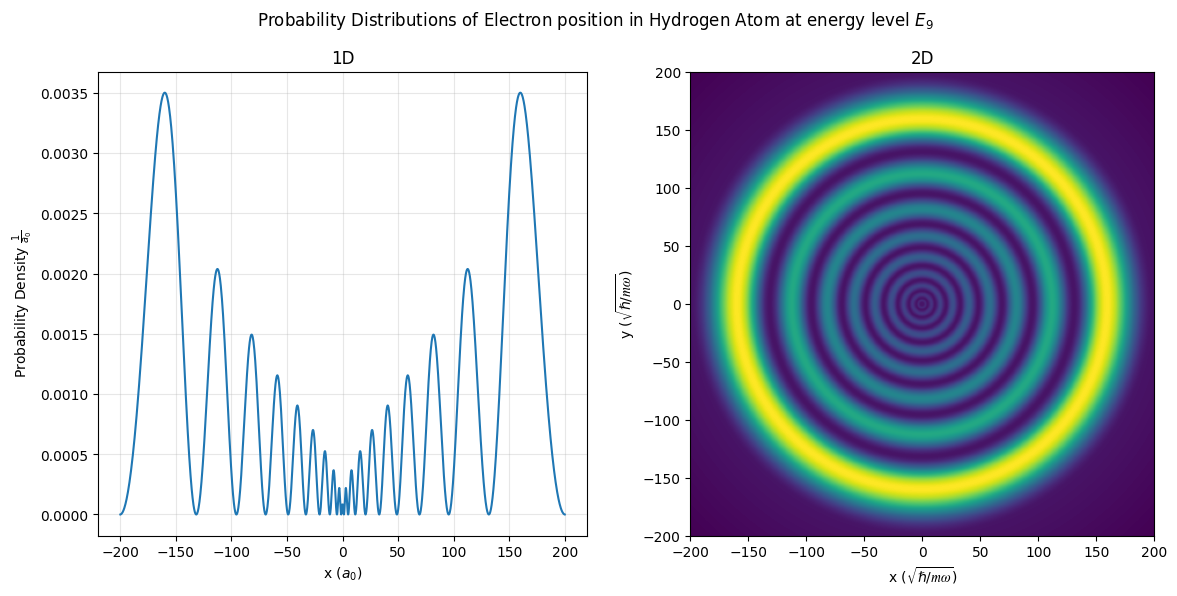

In [56]:
### - 2D Visualisations of Primary Quantum Number n

#User Settings
eigenval_selection = 9 # Eigenvalue number of the largest desired eigenvalue  // AKA 'n' the  primary quantum number
n=eigenval_selection # primary quantum number

#Interpolation of 1D results
interpolation_of_1d_result = interpolate.interp1d(r, E_vectors_hydrogen[:,eigenval_selection]**2, fill_value="extrapolate")  #Interolates the resulting radial function so i can use it to plot 2D and 3D representations without recalculating

#Creates meshgrids then calculates the radius of each point in the matrix/lattice
delta_r = 1                                                                                                 #Sets delta r as the pixel spacing 
X2d,Y2d = np.meshgrid(np.arange(-max_r, max_r+delta_r, delta_r), np.arange(-max_r, max_r+delta_r, delta_r)) #Creates a meshgrid of x, y points
radius_grid = np.sqrt(X2d**2+Y2d**2)                                                                        #Fills the X Y grid with the grid points radial seperation from 0,0

#Creates blank output image canvas
image = np.zeros((max_r*2+delta_r, max_r*2+delta_r))                 #Creates a zero filled array of the correct size for output image

#Processing 2D graphics output line by line similar to scan line tv
for row, _ in enumerate(X2d):                                        #Scans through row by row
    image[row] = interpolation_of_1d_result(radius_grid[row])        #Genrates the row for the image from the radial values in the grid and the interpolated function
    
# Plot set up
plt.subplots(nrows=2, ncols=1, figsize=(12, 6), tight_layout=True)
plt.suptitle("Probability Distributions of Electron position in Hydrogen Atom at energy level $E_%s$" %eigenval_selection )

# 1D Plot of original 1D data
plt.subplot(1,2,1)
title = "1D"
xlabel = "x $(a_0)$" 
ylabel = "Probability Density $\\frac{1}{a_0}$" 
SimplePlotAssist(r, E_vectors_hydrogen[:,eigenval_selection]**2, title=title, xlabel=xlabel, ylabel=ylabel)  #Plots the selected eigenvectors corresponding probability distribution
plt.plot(np.negative(r), E_vectors_hydrogen[:,eigenval_selection]**2, c="#1f77b4")                           #Again have mirrored the hydrogen data so that it covers both sides of the nucleus for visual comparison to the 2d rings image, colour used for the mirror inversion is hex code #1f77b4 which is the default matplot lib first line colour, to make it match the line above
plt.grid(alpha=0.3)

# 2D Plot of interpolated data
plt.subplot(1,2,2)
plt.imshow(image, extent=[X2d.min(),X2d.max(),Y2d.min(),Y2d.max()])
plt.title("2D")  
plt.xlabel("x $(\sqrt{ℏ/𝑚𝜔})$") 
plt.ylabel("y $(\sqrt{ℏ/𝑚𝜔})$") 
plt.show()



C:\Users\Ada\AppData\Local\Temp\ipykernel_36076\353378290.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


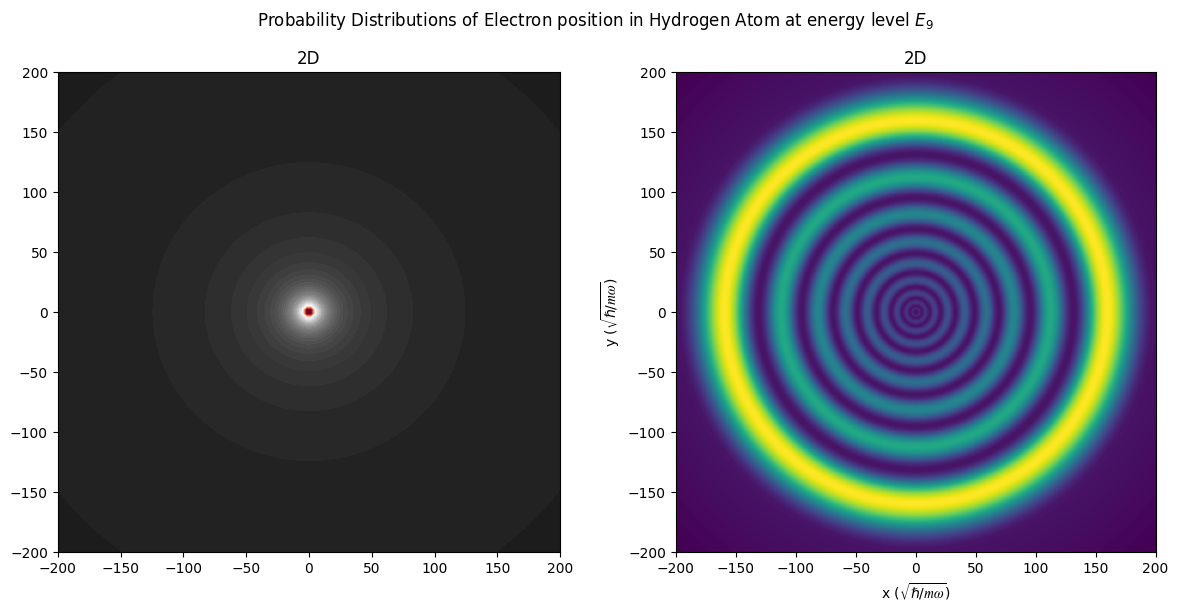

In [57]:
### - 2D Visualisations of Primary Quantum Number n

#User Settings
eigenval_selection = 9 # Eigenvalue number of the largest desired eigenvalue  // AKA 'n' the  primary quantum number
n=eigenval_selection # primary quantum number

#Interpolation of 1D results
interpolation_of_1d_result = interpolate.interp1d(r, E_vectors_hydrogen[:,eigenval_selection]**2, fill_value="extrapolate")  #Interolates the resulting radial function so i can use it to plot 2D and 3D representations without recalculating

#Creates meshgrids then calculates the radius of each point in the matrix/lattice
delta_r = 1                                                                                                 #Sets delta r as the pixel spacing 
X2d,Y2d = np.meshgrid(np.arange(-max_r, max_r+delta_r, delta_r), np.arange(-max_r, max_r+delta_r, delta_r)) #Creates a meshgrid of x, y points
radius_grid = np.sqrt(X2d**2+Y2d**2)                                                                        #Fills the X Y grid with the grid points radial seperation from 0,0

#Creates blank output image canvas
image = np.zeros((max_r*2+delta_r, max_r*2+delta_r))                 #Creates a zero filled array of the correct size for output image

#Processing 2D graphics output line by line similar to scan line tv
for row, _ in enumerate(X2d):                                        #Scans through row by row
    image[row] = interpolation_of_1d_result(radius_grid[row])        #Genrates the row for the image from the radial values in the grid and the interpolated function


# define x, y, and z values for the 3D plot

# Define the grid
x = np.linspace(-max_r, max_r, 100)
y = np.linspace(-max_r, max_r, 100)

X, Y = np.meshgrid(x, y)



# Define the function for the electric potential of a hydrogen atom
def hydrogen_potential(x, y, l):
    r = np.sqrt(x**2 + y**2)
    V_hyd = -2/r + (l*(l+1)/r**2)    
    return V_hyd


# Calculate the electric potential
V2 = hydrogen_potential(X, Y, l)

# Plot set up
plt.subplots(nrows=2, ncols=1, figsize=(12, 6), tight_layout=True)
plt.suptitle("Probability Distributions of Electron position in Hydrogen Atom at energy level $E_%s$" %eigenval_selection )

# 2d plot of potential for hydrogen atom
plt.subplot(1,2,1)
plt.title("potential")
plt.contourf(X, Y, V2, 100, cmap='RdGy')
plt.title("2D")  


# 2D Plot of interpolated data
plt.subplot(1,2,2)
plt.imshow(image, extent=[X2d.min(),X2d.max(),Y2d.min(),Y2d.max()])
plt.title("2D")  
plt.xlabel("x $(\sqrt{ℏ/𝑚𝜔})$") 
plt.ylabel("y $(\sqrt{ℏ/𝑚𝜔})$") 
plt.show()



In [58]:
### - Calculating radial maxima to plot 3D shells
eigenval_selection=9
density = E_vectors_hydrogen[:,eigenval_selection]**2
density_maxima_indexs = argrelmax(density)             #Finds the local energy maxima on the plot to the left above 
radial_maxima_values = r[density_maxima_indexs]        #Finds the corresponding r values for the maxima


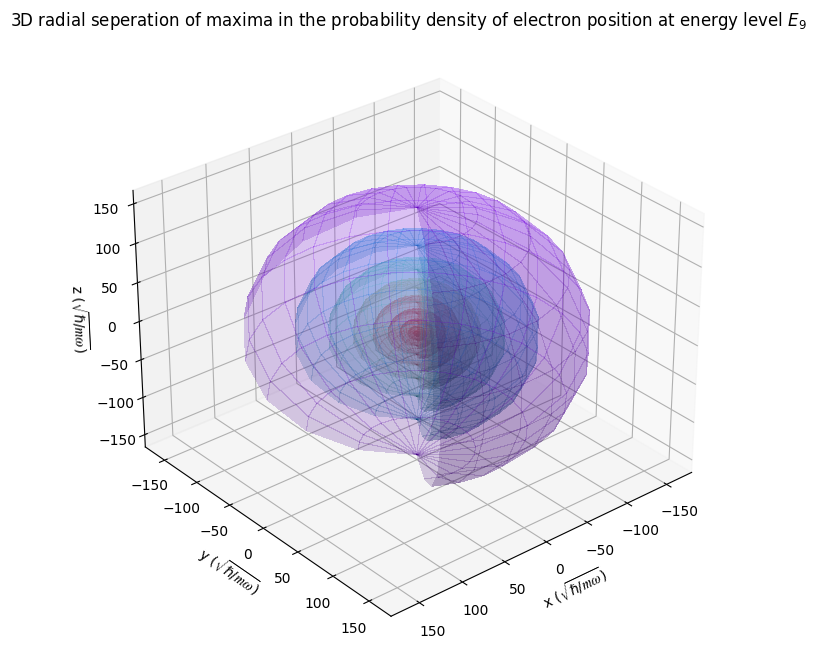

In [59]:
### - 3D Visualisation function for primary quantum number 'n'
def spherical_shells(radius, lines=20):
    """
    Input: radius: Radius spherical shells,
           lines: number of lines to draw the sphere frame from for the contour plot
    
    Returns: sphere_x: array of cartesisan x coordiantes for the sphere,
             sphere_y: array of cartesisan y coordiantes for the sphere,
             sphere_z: array of cartesisan z coordiantes for the sphere
    """
    circles = max(lines/2, 4)                                     #Sets number of horizontal circles to draw for the surface frame
    u, v = np.mgrid[1:1.8*np.pi:lines*1j, 0:np.pi:circles*1j]     #Creates a meshgrid of radial coordinate points, that fall on the sperical bound, only went from 1 to 1.8*pi so that the shpere will have a slice in it to see the inner spheres
    sphere_x = radius * np.cos(u) * np.sin(v)                     #Calculates cartesian x components           
    sphere_y = radius * np.sin(u) * np.sin(v)                     #Calculates cartesian x components 
    sphere_z = radius * np.cos(v)                                 #Calculates cartesian x components 
    return sphere_x, sphere_y, sphere_z                           #Returns x, y, z components 
 


### -  Plotting 3D Visualisations for primary quantum number 'n'

#Plot Setup
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
color = iter(cm.rainbow(np.linspace(0, 2, len(radial_maxima_values))))    #Sets a colour gradient for each successive sphere

#Plotting each shell
for shell_radius in reversed(radial_maxima_values):                       #Iterates through each shell Reversed the list of radial maxima so it plots from biggest to smallest ratehr than other way round, as the order of plotting sets the fore/back ground stacking
    c = next(color)                                                       #Iterates through the colour gradient selection
    wfx,wfy,wfz = spherical_shells(radius=shell_radius, lines=20)         #Caluclates the shells cartesian coordinates using the function created above
    ax.plot_surface(wfx,wfy, wfz, color=c, alpha=0.2, antialiased=False)  #Plots the shell, setting antialiased=False and alpha to low makes the shperes more transparent, neccessary to see the inner spheres

ax.set_xlim(-175,175)                                                     #After taking a slice out of the sphere the axis became lop sided so reset the limits on the shrunken axis to regain a 1:1:1 aspect ratio
ax.set_xlabel("x $(\sqrt{ℏ/𝑚𝜔})$") 
ax.set_ylabel("y $(\sqrt{ℏ/𝑚𝜔})$")
ax.set_zlabel("z $(\sqrt{ℏ/𝑚𝜔})$")
ax.set_title("3D radial seperation of maxima in the probability density of electron position at energy level $E_%s$" %n)   
ax.view_init(elev=30, azim=50)                                            #Set the plot viewing angle 

plt.show() 

The above plots show the effect on the radial probability maxima from changing the primary quantum number 'n'

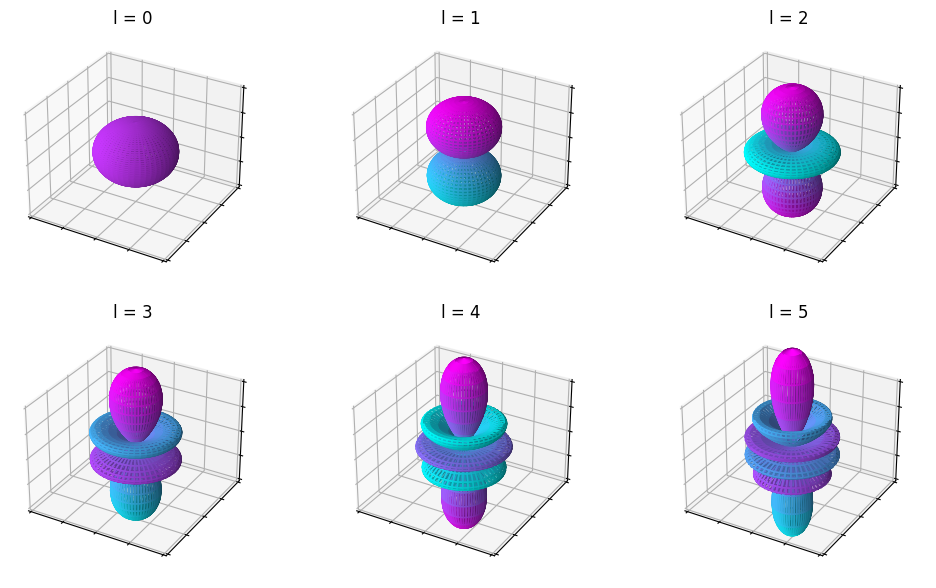

In [60]:
### - 3D Visualisations of angular momentum quantum number 'l'
def plot_3D_angular_wavefunction_probdensity(l, m=0):

    #Calcualte spherical harmonics
    r = 400                     
    phi = np.linspace(0, np.pi, 100)
    theta = np.linspace(0, 2*np.pi, 100)
    phi, theta = np.meshgrid(phi, theta)  #creates a meshgrid of radial coordiantes falling on the sphere defined by phi and theta
    Ylm = sph_harm(m,l,theta, phi).real   #this is psi angular aka the angular eignefunction probability densiities?

    #Convert spherical coordinates to Cartesian
    x_coord = r * np.sin(phi) * np.cos(theta) * abs(Ylm)
    y_coord = r * np.sin(phi) * np.sin(theta) * abs(Ylm)
    z_coord = r * np.cos(phi) * abs(Ylm)

    #Create a colour map
    term_1 = (Ylm - Ylm.min())                    #Moves lower limit to 0
    term_2 = (Ylm.max() - Ylm.min())              #Normalises upper limit to 1
    if term_2 == 0:                               #Checks for 0 values in divide, which occur when l = 0
        fcolors = Ylm + 0.5                       #Sets a constant colour for this case of l = 0 as there is only one spherical orbital and it needs no colour differentiation to make it out visually
    else:
        fcolors = term_1/term_2                   #Otherwise sets the normalised colour gradient
    
    #Plotting
    ax.plot_surface(x_coord, y_coord, z_coord, facecolors=cm.cool(fcolors), alpha=0.4)   #Plots the surface using the normalised colour gradient, setting alpha to 0.4 makes the plots geometry look better
    ax.set_xlim(-max_r, max_r)
    ax.set_ylim(-max_r, max_r)
    ax.set_zlim(-max_r, max_r)  
    return (x_coord, y_coord, z_coord)                                                   #Returns cartsian x, y, z coordinates


#Make 3D plots of angular wavefunction probability densities for hydrogen atom varying l 
fig = plt.figure(figsize=(12,7))
for l in range (0,6):                                        #Iterates through l values
    ax = fig.add_subplot(2, 3, l+1, projection='3d')         
    plot_3D_angular_wavefunction_probdensity(l, m=0)         #Plots the angular wavefunction 
    ax.set_title("l = %s" %l)
    ax.set_xticklabels([])                                   #Removes the plot value labels without removing the grid
    ax.set_yticklabels([])                                   #As above
    ax.set_zticklabels([])                                   #As above
plt.show()

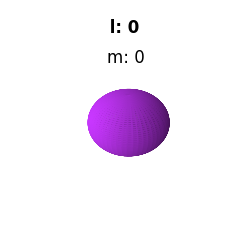

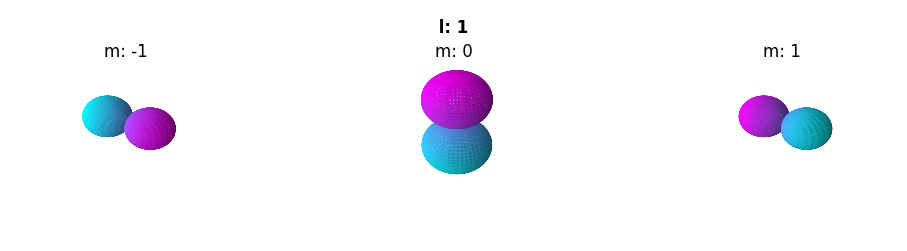

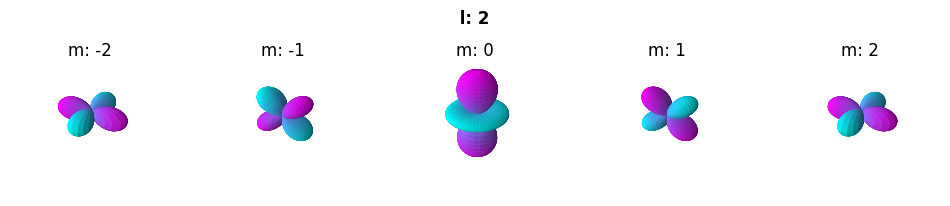

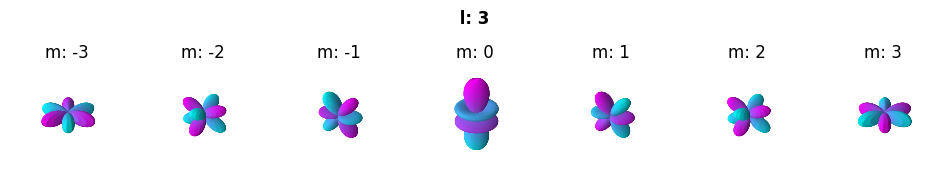

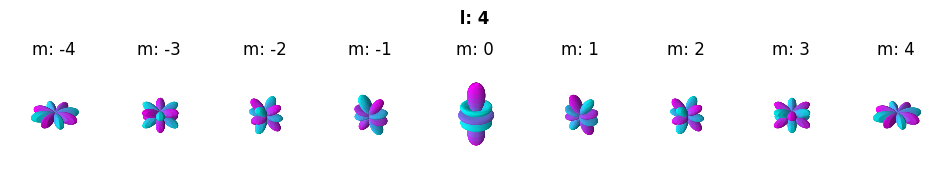

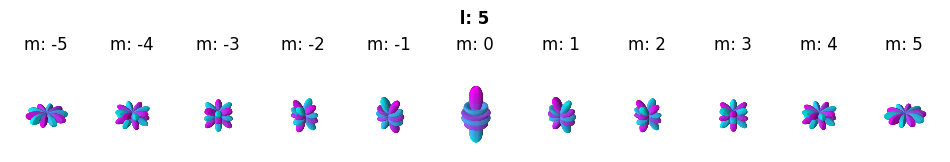

In [61]:
#Make 3D plots of angular wavefunction probability densities for hydrogen atom varying l and m

#User Settings
max_n = 6 #Setting for the maximum value of n to go up to // beware, values over 6 end up with very cramped plots 

for l in range (0, max_n):                      #Iterates through l values, l goes from 0 to n-1
    fig = plt.figure(figsize=(12, 3))
    
    for m in range (-l,l+1):                    #Iterates through m values, m goes from -l to l
        ax = fig.add_subplot(1, (l*2)+1, m+l+1, projection='3d')    #Sets the plot position from the values of l and m for that strip
        plt.suptitle("     l: %s" %l, fontweight='bold', y=0.85)    #Sets title for each genration of l
        plot_3D_angular_wavefunction_probdensity(l, m=m)            
        ax.set_title("m: %s" %m, y=0.8 + (l**2/40))                 #(l**2/40) is just a scaling factor that slightly moves the subtitles as they get closer to the plots each time due to the plot getting wider automatically as l increases
        ax.axis('off')                                              #Hides the plot axis for a better visual experience
    plt.show()

Report:

To find the values of the allowed energy eigenvalues of a quantum system we have to apply the hamiltonian opperator to the wavefunction $(\psi)$. To simplify the problem we have taken it in one dimension and in time independsnt form where the wavefuntion is just a function of $x$ $\psi(x)$


$$H \psi(x) = E \psi(x)$$


The Hamiltonian $H$ is given by 


$$H = \frac{-\hbar^2}{2m}\frac{d^2}{dx^2} + V $$


it contains two terms, the potential energy term V and the kinetic energy term D where 


$$D = \frac{-\hbar^2}{2m}\frac{d^2}{dx^2}$$


the potential term can be implemented easily as a simple function, however D requires the use of numerical methods as it contains a continuous derivative.


Given this, the hamiltonian is implemented as a matrix equation, with $\psi$ an $N$-dimensional vector, and $H$ an $(N \times N)$ matrix.


The matrix is symmetric, we can find the eigenvalues and eigenfunctions of the matrix using readily availibly pyton routines from the scipy libraries. I chose to test two solvers, scipy.linalg.eig and scipy.linalg.eigh_tridiagonal to compare their results. At first the eig fucntion was returning some strange results but then i realised the returned values were not sorted, so after adding a quicksort function via np.sort() it returned the exact same results as the eigh_tridiagonal function.

As both function methods returned the exact same results it would be down to compute resources rather than accuracy to pick one, i did not implement a time loop to test the difference as my code is alredy substantial. Without having tested it i would pick using the eigh_tridiagonal function as it requires a much simpler hamiltonian function, less memory usage from not having to store the majority 0 valued matricies, and requires no np.sort to return the results.

Testing both methods on the QHO problem and then comparing the Eigenvalues to the analytical results showed that the solvers can provide acuurate results for the QHO up to around an E_n value of 10. I then did the same for comparing eigenvectors to the analytical results but only the first 4 terms. The results of the solvers come out exactly mathcing the analytical eigenvectors albeit with a scale mismatch that i assume is down to a unit conversion scaling.

Then made some interesting plots of the wavefunctions and probability distributions for a range of the QHO's energy eigenstates, including one which overlayed the potental with the wavefunctions to demonstrate the mismatch in classical and quantum theory in the ability of the wavefucntion to have a value outside of the classicly deifned turning points.

Moved on to the hydrogen atom where ran through the same as for the QHO. Compared the potential of the QHO to the Hydrogen atom which showed interesting differences in the two systems. Also compared the analytical hydrogen eigenvalues with the solvers which provide accurate results up till around E_n 20 this time.

The previous visuals were all based on the radial wavefunction which each have a unique energy value, but the total wavefucntion for the hydrogen atom consists of the radial wavefunction and the angular wavefunction which gives each energy level above n=1 more than one possible state, they are degenerate. Created visulisations for the hydrogen atoms l and m quantum numbers in 2 and 3D to show how the various numbers effect the probability distribution of the electron, showing the degenerate states that give rise to the s, p... orbital shells.
